In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unittest
import time
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from typing import Literal, Optional
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42

## Реализация метрик

In [4]:
def my_mse(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

def my_mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

def my_r2(y_true, y_pred, force_finite=True):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.size < 2:
        return np.nan

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)

    if ss_tot == 0:
        if force_finite:
            return 1.0 if ss_res == 0 else 0.0
        else:
            return np.nan if ss_res == 0 else -np.inf

    r2 = 1 - (ss_res / ss_tot)

    return r2

def my_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = np.finfo(float).eps
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon, np.abs(y_true))))

In [5]:
def test_metric(my_metric, sklearn_metric, *args, **kwargs):
    test_data = [
        {
            'y_true': [3, -0.5, 2, 7],
            'y_pred': [2.5, 0.0, 2, 8],
        },
        {
            'y_true': [5, 5, 5],
            'y_pred': [5, 5, 5],
        },
        {
            'y_true': [5, 5, 5],
            'y_pred': [4, 5, 6],
        },
        {
            'y_true': [0, 1, 2],
            'y_pred': [0.1, 1.1, 2.1],
        },
        {
            'y_true': [5],
            'y_pred': [3],
        },
        {
            'y_true': [2, 2, 2],
            'y_pred': [3, 3, 3],
        },
    ]

    for data in test_data:
        y_true = data['y_true']
        y_pred = data['y_pred']

        assert np.isclose(
            sklearn_metric(y_true, y_pred, *args, **kwargs),
            my_metric(y_true, y_pred, *args, **kwargs),
            equal_nan=True,
            atol=1e-11
        )

In [6]:
test_metric(my_mse, mean_squared_error)
test_metric(my_mae, mean_absolute_error)
test_metric(my_mape, mean_absolute_percentage_error)
test_metric(my_r2, r2_score)
test_metric(my_r2, r2_score, force_finite=False)

## Реализация классов для масштабирования

In [7]:
class MyStandardScaler:
    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        X = np.asarray(X)
        if self.with_mean:
            self.mean_ = np.mean(X, axis=0)
        if self.with_std:
            self.scale_ = np.std(X, axis=0)
            if isinstance(self.scale_, np.ndarray):
                self.scale_[self.scale_ == 0] = 1.0
            elif self.scale_ == 0:
                self.scale_ = 1.0
        return self

    def transform(self, X):
        if self.mean_ is None or (self.with_std and self.scale_ is None):
            raise ValueError("Not fitted")

        X = np.asarray(X)
        if self.with_mean:
            X = X - self.mean_
        if self.with_std:
            X = X / self.scale_
        return X

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [8]:
class MyMinMaxScaler:
    def __init__(self, feature_range=(0, 1), clip=False):
        self.feature_range = feature_range
        self.clip = clip
        self.min_ = None
        self.scale_ = None
        self.data_min_ = None
        self.data_max_ = None

    def fit(self, X):
        X = np.asarray(X)
        self.data_min_ = np.min(X, axis=0)
        self.data_max_ = np.max(X, axis=0)

        if isinstance(self.data_min_, np.ndarray):
            scale = self.data_max_ - self.data_min_
            scale[scale == 0] = 1.0
        else:
            scale = self.data_max_ - self.data_min_ if (self.data_max_ - self.data_min_) != 0 else 1.0

        self.min_ = self.data_min_
        self.scale_ = scale
        return self

    def transform(self, X):
        if self.min_ is None or self.scale_ is None:
            raise ValueError("Not fitted")

        X = np.asarray(X)
        X_std = (X - self.min_) / self.scale_
        X_scaled = X_std * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]

        if self.clip:
            np.clip(X_scaled, self.feature_range[0], self.feature_range[1], out=X_scaled)
        return X_scaled

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [9]:
def test_scaler(my_scaler, sklearn_scaler):
    test_data = [
        [[1, 2, 3], [4, 5, 6]],
        [[0, 0, 0], [1, 1, 1]],
        [[-1, 0, 1], [-2, 0, 2], [-3, 0, 3]],
        [[0, -1, 1], [0, -2, 2], [0, -3, 3]],
        [[100], [200], [300]],
        [[1, 1, 1], [1, 1, 1]]
    ]

    for data in test_data:
        X = np.array(data, dtype=float)

        sklearn_result = sklearn_scaler.fit_transform(X)
        my_result = my_scaler.fit_transform(X)

        assert np.allclose(sklearn_result, my_result, atol=1e-11)

In [10]:
test_scaler(MyStandardScaler(), StandardScaler())
test_scaler(MyMinMaxScaler(), MinMaxScaler())

## Реализация классов для кросс-валидации

In [11]:
class MyKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)

        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(indices)

        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            train_indices = np.concatenate([indices[:start], indices[stop:]])
            yield train_indices, test_indices
            current = stop

In [12]:
class MyLeaveOneOut:
    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)

        for i in range(n_samples):
            test_indices = np.array([i])
            train_indices = np.concatenate([indices[:i], indices[i+1:]])
            yield train_indices, test_indices

In [13]:
def test_cv(my_cv, sklearn_cv):
    X = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    my_splits = list(my_cv.split(X))
    sklearn_splits = list(sklearn_cv.split(X))

    for (my_train, my_test), (sklearn_train, sklearn_test) in zip(my_splits, sklearn_splits):
        assert np.array_equal(my_train, sklearn_train)
        assert np.array_equal(my_test, sklearn_test)

In [14]:
test_cv(MyKFold(), KFold())
test_cv(MyLeaveOneOut(), LeaveOneOut())

## Реализация линейной регрессии

In [15]:
class MyLinearRegression:
    def __init__(
        self,
        solver: Literal['analytical', 'gradient', 'stochastic'] = 'analytical',
        penalty: Optional[Literal['l1', 'l2', 'elasticnet', 'lp']] = None,
        alpha: float = 1.0,
        l1_ratio: float = 0.5,
        p: int = 2,
        learning_rate: float = 0.01,
        max_iter: int = 1000,
        tol: float = 1e-4,
        batch_size: int = 32,
        verbose: bool = True,
        random_state: Optional[int] = None
    ):
        self.solver = solver
        self.penalty = penalty
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.p = p
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
        self.verbose = verbose
        self.random_state = random_state

        self.coef_ = None
        self.intercept_ = None

        self._validate_params()

    def _validate_params(self):
        if self.solver not in {'analytical', 'gradient', 'stochastic'}:
            raise ValueError(f"Invalid solver: {self.solver}")
        if self.penalty not in {None, 'l1', 'l2', 'elasticnet', 'lp'}:
            raise ValueError(f"Invalid penalty: {self.penalty}")
        if self.penalty == 'elasticnet' and not (0 <= self.l1_ratio <= 1):
            raise ValueError("l1_ratio must be in [0, 1] for 'elasticnet'")
        if self.penalty == 'lp' and self.p < 1:
            raise ValueError("p must be >= 1 for 'lp' penalty")

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def _compute_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = X @ self.coef_
        mse = np.mean((y_pred - y) ** 2)
        if self.penalty is None:
            return mse

        coef_ = self.coef_[1:]
        if self.penalty == 'l1':
            reg = self.alpha * np.sum(np.abs(coef_))
        elif self.penalty == 'l2':
            reg = self.alpha * np.sum(coef_ ** 2)
        elif self.penalty == 'elasticnet':
            reg = self.alpha * (
                self.l1_ratio * np.sum(np.abs(coef_)) +
                (1 - self.l1_ratio) * np.sum(coef_ ** 2)
            )
        elif self.penalty == 'lp':
            reg = self.alpha * np.sum(np.abs(coef_) ** self.p)
        return mse + reg

    def _compute_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        n_samples = X.shape[0]
        error = X @ self.coef_ - y
        gradient = (2 / n_samples) * X.T @ error

        if self.penalty is not None:
            reg_gradient = np.zeros_like(self.coef_)
            coef_ = self.coef_[1:]
            if self.penalty == 'l1':
                reg_gradient[1:] = self.alpha * np.sign(coef_)
            elif self.penalty == 'l2':
                reg_gradient[1:] = 2 * self.alpha * coef_
            elif self.penalty == 'elasticnet':
                reg_gradient[1:] = (
                    self.alpha * self.l1_ratio * np.sign(coef_) +
                    2 * self.alpha * (1 - self.l1_ratio) * coef_
                )
            elif self.penalty == 'lp':
                reg_gradient[1:] = self.alpha * self.p * np.sign(coef_) * (np.abs(coef_) ** (self.p - 1))
            gradient += reg_gradient

        return gradient

    def _initialize_weights(self, n_features: int):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.coef_ = np.random.randn(n_features)

    def fit_analytical(self, X: np.ndarray, y: np.ndarray):
        X_ext = self._add_intercept(X)
        if self.penalty is None:
            self.coef_ = np.linalg.pinv(X_ext.T @ X_ext) @ X_ext.T @ y
        elif self.penalty == 'l2':
            identity = np.eye(X_ext.shape[1])
            identity[0, 0] = 0
            self.coef_ = np.linalg.inv(X_ext.T @ X_ext + self.alpha * identity) @ X_ext.T @ y
        else:
            print(f"Warning: Falling back to gradient descent for penalty '{self.penalty}'")
            self.fit_gradient(X, y)
            return
        self.intercept_, self.coef_ = self.coef_[0], self.coef_[1:]

    def fit_gradient(self, X: np.ndarray, y: np.ndarray):
        X_ext = self._add_intercept(X)
        self._initialize_weights(X_ext.shape[1])

        iterator = range(self.max_iter)
        if self.verbose:
            iterator = tqdm(iterator, desc="Gradient Descent")

        prev_loss = float('inf')
        for i in iterator:
            gradient = self._compute_gradient(X_ext, y)
            self.coef_ -= self.learning_rate * gradient
            loss = self._compute_loss(X_ext, y)
            if abs(prev_loss - loss) < self.tol:
                if self.verbose:
                    print(f"Early stopping at iteration {i}")
                break
            prev_loss = loss

        self.intercept_, self.coef_ = self.coef_[0], self.coef_[1:]

    def fit_stochastic(self, X: np.ndarray, y: np.ndarray):
        X_ext = self._add_intercept(X)
        n_samples = X_ext.shape[0]
        self._initialize_weights(X_ext.shape[1])

        iterator = range(self.max_iter)
        if self.verbose:
            iterator = tqdm(iterator, desc="Stochastic Gradient Descent")

        prev_loss = float('inf')
        for i in iterator:
            indices = np.random.permutation(n_samples)
            X_shuffled, y_shuffled = X_ext[indices], y[indices]
            for j in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[j:j + self.batch_size]
                y_batch = y_shuffled[j:j + self.batch_size]
                gradient = self._compute_gradient(X_batch, y_batch)
                self.coef_ -= self.learning_rate * gradient

            loss = self._compute_loss(X_ext, y)
            if abs(prev_loss - loss) < self.tol:
                if self.verbose:
                    print(f"Early stopping at iteration {i}")
                break
            prev_loss = loss

        self.intercept_, self.coef_ = self.coef_[0], self.coef_[1:]

    def fit(self, X: np.ndarray, y: np.ndarray):
        if self.solver == 'analytical':
            self.fit_analytical(X, y)
        elif self.solver == 'gradient':
            self.fit_gradient(X, y)
        elif self.solver == 'stochastic':
            self.fit_stochastic(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.coef_ is None or self.intercept_ is None:
            print('HERE')
            raise RuntimeError("Model must be fitted before prediction.")
        return self.intercept_ + X @ self.coef_

In [16]:
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name:26} | MSE: {mse:10.4f} | R2: {r2:.4f}")
    return mse, r2

def time_model(model, X, y, n_runs=15):
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        times.append(end - start)

    return {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times)
    }

def plot_results(results):
    models = list(results.keys())
    mse_values = [results[model][0] for model in models]
    r2_values = [results[model][1] for model in models]

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.barh(models, mse_values, color=['blue' if 'sklearn' in m else 'orange' for m in models])
    plt.xlabel('MSE')
    plt.title('MSE Сравнение')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.barh(models, r2_values, color=['blue' if 'sklearn' in m else 'orange' for m in models])
    plt.xlabel('R2')
    plt.title('R2 Сравнение')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


Метрики sklearn моделей
sklearn Linear             | MSE:   380.4766 | R2: 0.9774
sklearn Ridge              | MSE:   380.2125 | R2: 0.9774
sklearn Lasso              | MSE:   396.2790 | R2: 0.9765
sklearn ElasticNet         | MSE:  2364.0074 | R2: 0.8596

Метрики кастомных моделей
Custom Analytical          | MSE:   380.4766 | R2: 0.9774
Custom Analytical L2       | MSE:   380.2125 | R2: 0.9774
Custom Gradient L1         | MSE:   385.8448 | R2: 0.9771
Custom Gradient L2         | MSE:  4677.3278 | R2: 0.7222
Custom Gradient ElasticNet | MSE:  2330.3073 | R2: 0.8616
Custom SGD L2              | MSE:  4661.5790 | R2: 0.7231

Время обучения кастомных моделей
Custom Analytical          | Time: 0.0003s +- 0.0001s
Custom Analytical L2       | Time: 0.0006s +- 0.0015s
Custom Gradient            | Time: 0.0717s +- 0.0281s
Custom Gradient L2         | Time: 0.0381s +- 0.0087s
Custom Stochastic          | Time: 0.1527s +- 0.0914s
Custom Stochastic L2       | Time: 1.1991s +- 0.3286s

Время обу

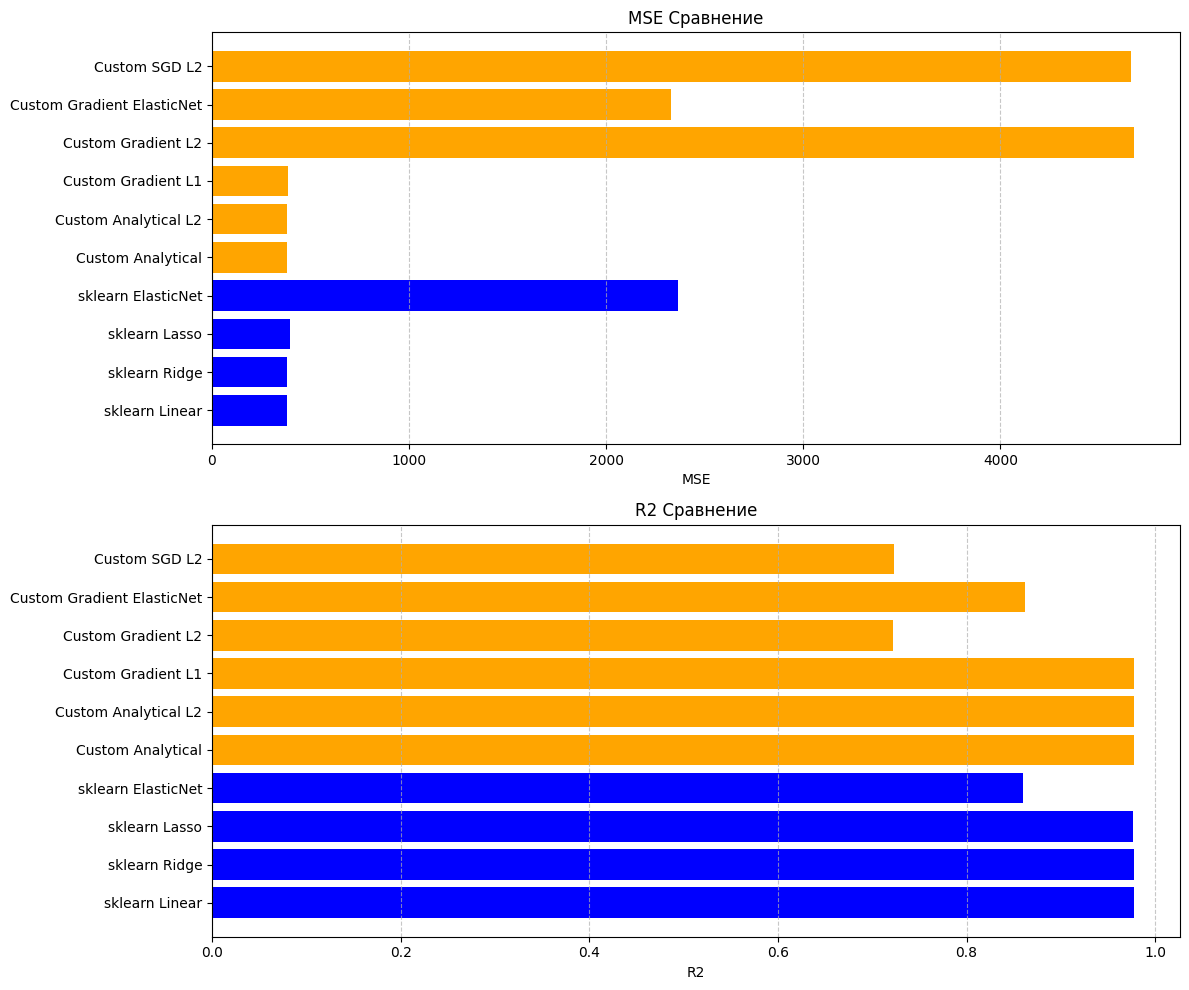

In [17]:
X, y = make_regression(n_samples=1000, n_features=10, noise=20, random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

models = {
    "sklearn Linear": LinearRegression(),
    "sklearn Ridge": Ridge(alpha=1.0),
    "sklearn Lasso": Lasso(alpha=1.0),
    "sklearn ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)
}

print("\n" + "="*57)
print("Метрики sklearn моделей")
print("="*57)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = evaluate_model(name, y_test, y_pred)

custom_models = {
    "Custom Analytical": MyLinearRegression(solver='analytical', verbose=False),
    "Custom Analytical L2": MyLinearRegression(solver='analytical', penalty='l2', alpha=1.0, verbose=False),
    "Custom Gradient L1": MyLinearRegression(solver='gradient', penalty='l1', alpha=1.0, verbose=False),
    "Custom Gradient L2": MyLinearRegression(solver='gradient', penalty='l2', alpha=1.0, verbose=False),
    "Custom Gradient ElasticNet": MyLinearRegression(
        solver='gradient', penalty='elasticnet', alpha=1.0, l1_ratio=0.5, verbose=False
    ),
    "Custom SGD L2": MyLinearRegression(
        solver='stochastic', penalty='l2', alpha=1.0, batch_size=32, verbose=False
    )
}

print("\n" + "="*57)
print("Метрики кастомных моделей")
print("="*57)

for name, model in custom_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = evaluate_model(name, y_test, y_pred)

print("\n" + "="*57)
print("Время обучения кастомных моделей")
print("="*57)

for solver in ['analytical', 'gradient', 'stochastic']:
    for penalty in [None, 'l2']:
        name = f"Custom {solver.capitalize()}"
        if penalty:
            name += f" {penalty.upper()}"
        model = MyLinearRegression(solver=solver, penalty=penalty, alpha=1.0, verbose=False)
        timing = time_model(model, X_train_scaled, y_train)
        print(f"{name:26} | Time: {timing['mean']:.4f}s +- {timing['std']:.4f}s")

print("\n" + "="*57)
print("Время обучения sklearn моделей")
print("="*57)

for name, model in models.items():
    if name in ["sklearn Linear", "sklearn Ridge"]:
        timing = time_model(model, X_train_scaled, y_train)
        print(f"{name:26} | Time: {timing['mean']:.4f}s +- {timing['std']:.4f}s")

plot_results(results)

## Загрузка данных

In [18]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [19]:
display(train.head(), test.head())

ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   

   ...  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0  ...          Employed       Associate         4.0   35067.0   
1  ...          Employed     High School        33.0   27001.0   
2  ...          Employed        Bachelor        28.0  278382.0   
3  ...          Employed     High School         0.0    9224.0   
4  ...          Employed        Bachelor        31.0    4502.0   

   BaseInterestRate InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.257790     0.251465          508.970230                0.288013   
1          0.086110     0.093173          514.675859                0.050585   
2          0.108436     0.115443         1268.276385                0.072571   
3          0.100686     0.112822          498.505187                0.225415   
4          0.110437     0.089037          756.035156                0.052721   

   LoanApproved  RiskScore  
0           0.0  66.176500  
1           1.0  28.495737  
2           1.0  34.488104  
3           1.0  36.910753  
4           1.0  31.347091  

[5 rows x 36 columns]

ID ApplicationDate  Age  AnnualIncome  CreditScore  LoanAmount  \
0   0      1979-01-03   49        207095          850       14458   
1   1      2006-04-10   28         64653          674       65491   
2   2      2013-11-28   41        300000          768       16811   
3   3      1995-08-24   50        300000          850       48737   
4   4      1980-06-15   35        300000          672       51916   

   LoanDuration MaritalStatus  NumberOfDependents HomeOwnershipStatus  ...  \
0            60        Single                   0                Rent  ...   
1            48        Single                   2                 Own  ...   
2            60        Single                   1                 Own  ...   
3            36      Divorced                   0            Mortgage  ...   
4            60        Single                   6            Mortgage  ...   

   JobTenure  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0          6          Employed     High School          23     10626   
1          3          Employed     High School           3    299024   
2          3          Employed     High School          19      6979   
3          3     Self-Employed        Bachelor          26      8438   
4          7          Employed       Associate          12    436216   

   BaseInterestRate InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.104458     0.125350          325.532336                0.040650   
1          0.233491     0.260561         2210.247757                0.454410   
2          0.147811     0.154571          403.977431                0.034919   
3          0.118737     0.099712         1571.946906                0.085558   
4          0.230916     0.237727         1486.675235                0.063707   

   LoanApproved  
0             1  
1             0  
2             1  
3             1  
4             1  

[5 rows x 36 columns]

## EDA

### Первичный осмотр

In [20]:
train.shape

(11017, 36)

In [21]:
test.shape

(5000, 36)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          5000 non-null   int64  
 1   ApplicationDate             5000 non-null   object 
 2   Age                         5000 non-null   int64  
 3   AnnualIncome                5000 non-null   int64  
 4   CreditScore                 5000 non-null   int64  
 5   LoanAmount                  5000 non-null   int64  
 6   LoanDuration                5000 non-null   int64  
 7   MaritalStatus               5000 non-null   object 
 8   NumberOfDependents          5000 non-null   int64  
 9   HomeOwnershipStatus         5000 non-null   object 
 10  MonthlyDebtPayments         5000 non-null   int64  
 11  CreditCardUtilizationRate   5000 non-null   float64
 12  NumberOfOpenCreditLines     5000 non-null   int64  
 13  NumberOfCreditInquiries     5000 

In [24]:
train.describe()

Age   AnnualIncome  CreditScore     LoanAmount  LoanDuration  \
count  10487.000000   10487.000000  9986.000000    9986.000000  10487.000000   
mean      39.850386  131587.872127   678.082716   29874.218306     53.439878   
std       11.614132  115791.941909   175.192486   27705.509722     24.493562   
min       18.000000   15000.000000   300.000000    1063.000000     12.000000   
25%       32.000000   20959.500000   550.000000   12658.000000     36.000000   
50%       40.000000   89015.000000   722.500000   21828.500000     48.000000   
75%       48.000000  257025.000000   850.000000   37158.000000     60.000000   
max       80.000000  748508.000000   850.000000  418997.000000    120.000000   

       NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
count        10487.000000          9986.000000               10487.000000   
mean             1.568323           546.458642                   0.284397   
std              1.418684           501.981888                   0.159240   
min              0.000000            13.000000                   0.003674   
25%              0.000000           233.250000                   0.158929   
50%              1.000000           398.000000                   0.262229   
75%              3.000000           685.000000                   0.391683   
max              6.000000         10879.000000                   0.914635   

       NumberOfOpenCreditLines  NumberOfCreditInquiries  ...  \
count             10487.000000             10487.000000  ...   
mean                  3.033565                 0.979498  ...   
std                   1.740186                 0.990927  ...   
min                   0.000000                 0.000000  ...   
25%                   2.000000                 0.000000  ...   
50%                   3.000000                 1.000000  ...   
75%                   4.000000                 2.000000  ...   
max                  12.000000                 6.000000  ...   

       UtilityBillsPaymentHistory     JobTenure    Experience      NetWorth  \
count                10487.000000  10487.000000  10487.000000  9.986000e+03   
mean                     0.784428      4.949271     17.628302  1.542381e+05   
std                      0.123039      2.201100     11.337248  4.622229e+05   
min                      0.259301      0.000000      0.000000  1.004000e+03   
25%                      0.708475      3.000000      9.000000  7.252500e+03   
50%                      0.803692      5.000000     17.000000  2.742950e+04   
75%                      0.879312      6.000000     26.000000  1.241758e+05   
max                      0.996573     17.000000     57.000000  1.126117e+07   

       BaseInterestRate  InterestRate  MonthlyLoanPayment  \
count       9986.000000  10487.000000        10487.000000   
mean           0.200392      0.200112         1075.622426   
std            0.094388      0.096458         1344.053181   
min            0.052494      0.046445           30.008506   
25%            0.119908      0.119548          375.872620   
50%            0.182023      0.180710          684.878529   
75%            0.264709      0.264880         1279.930203   
max            0.722497      0.833647        29634.807816   

       TotalDebtToIncomeRatio  LoanApproved     RiskScore  
count            10487.000000  10487.000000  1.048700e+04  
mean                 0.517577      0.511776 -2.569878e+04  
std                  0.894637      0.499885  1.431675e+06  
min                  0.006064      0.000000 -9.999999e+06  
25%                  0.066734      0.000000  3.256475e+01  
50%                  0.178193      1.000000  4.411876e+01  
75%                  0.637457      1.000000  6.535690e+01  
max                 24.383046      1.000000  1.000000e+07  

[8 rows x 30 columns]

In [25]:
prepared_train = train.copy()
prepared_test = test.copy()

### Проверка на наличие пропусков

In [26]:
def count_missings(df: pd.DataFrame):
    missing_data = df.isnull().sum()

    missing_percent = (missing_data / len(df)) * 100

    missing_info = pd.DataFrame({
        'missing_values': missing_data,
        'missing_percent': missing_percent,
        'type': train.dtypes
    })

    missing_info = missing_info[missing_info['missing_values'] > 0].sort_values(by='missing_values', ascending=False)

    return missing_info

In [27]:
count_missings(prepared_train)

missing_values  missing_percent     type
CreditScore                           1031         9.358265  float64
BankruptcyHistory                     1031         9.358265  float64
MonthlyDebtPayments                   1031         9.358265  float64
LoanAmount                            1031         9.358265  float64
NetWorth                              1031         9.358265  float64
BaseInterestRate                      1031         9.358265  float64
TotalAssets                           1031         9.358265  float64
LoanPurpose                           1031         9.358265   object
CheckingAccountBalance                1031         9.358265  float64
AnnualIncome                           530         4.810747  float64
ApplicationDate                        530         4.810747   object
Age                                    530         4.810747  float64
NumberOfOpenCreditLines                530         4.810747  float64
CreditCardUtilizationRate              530         4.810747  float64
DebtToIncomeRatio                      530         4.810747  float64
NumberOfCreditInquiries                530         4.810747  float64
NumberOfDependents                     530         4.810747  float64
HomeOwnershipStatus                    530         4.810747   object
MaritalStatus                          530         4.810747   object
LoanDuration                           530         4.810747  float64
SavingsAccountBalance                  530         4.810747  float64
LengthOfCreditHistory                  530         4.810747  float64
PaymentHistory                         530         4.810747  float64
PreviousLoanDefaults                   530         4.810747  float64
UtilityBillsPaymentHistory             530         4.810747  float64
JobTenure                              530         4.810747  float64
TotalLiabilities                       530         4.810747  float64
MonthlyIncome                          530         4.810747  float64
EducationLevel                         530         4.810747   object
EmploymentStatus                       530         4.810747   object
Experience                             530         4.810747  float64
InterestRate                           530         4.810747  float64
MonthlyLoanPayment                     530         4.810747  float64
TotalDebtToIncomeRatio                 530         4.810747  float64
LoanApproved                           530         4.810747  float64
RiskScore                              530         4.810747  float64

Удалим строки с пропуском в `RiskScore`. Их всего - `4.8%`, что не критично.

In [28]:
prepared_train = prepared_train.dropna(subset=['RiskScore']).reset_index(drop=True)

prepared_train['RiskScore'].isna().sum()

np.int64(0)

In [29]:
count_missings(prepared_train)

missing_values  missing_percent     type
CreditScore                        501         4.777343  float64
LoanAmount                         501         4.777343  float64
MonthlyDebtPayments                501         4.777343  float64
BankruptcyHistory                  501         4.777343  float64
LoanPurpose                        501         4.777343   object
CheckingAccountBalance             501         4.777343  float64
TotalAssets                        501         4.777343  float64
NetWorth                           501         4.777343  float64
BaseInterestRate                   501         4.777343  float64

Остальные пропуски заполним `медианой` для числовых столбцов и `модой` для категориальных.

In [30]:
for column in prepared_train.select_dtypes(include=['float64']).columns:
    prepared_train[column] = prepared_train[column].fillna(prepared_train[column].median())

for column in prepared_train.select_dtypes(include=['object']).columns:
    prepared_train[column] = prepared_train[column].fillna(prepared_train[column].mode()[0])

In [31]:
count_missings(prepared_train)

Empty DataFrame
Columns: [missing_values, missing_percent, type]
Index: []

In [32]:
count_missings(prepared_test)

Empty DataFrame
Columns: [missing_values, missing_percent, type]
Index: []

### Проверка на наличие дубликатов

In [33]:
prepared_train.duplicated().sum()

np.int64(487)

In [34]:
prepared_test.duplicated().sum()

np.int64(0)

Удалим дубликаты.

In [35]:
prepared_train.drop_duplicates(inplace=True)

prepared_train.duplicated().sum()

np.int64(0)

### Проверка типов

In [36]:
prepared_train.dtypes

ApplicationDate                object
Age                           float64
AnnualIncome                  float64
CreditScore                   float64
LoanAmount                    float64
LoanDuration                  float64
MaritalStatus                  object
NumberOfDependents            float64
HomeOwnershipStatus            object
MonthlyDebtPayments           float64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines       float64
NumberOfCreditInquiries       float64
DebtToIncomeRatio             float64
BankruptcyHistory             float64
LoanPurpose                    object
PreviousLoanDefaults          float64
PaymentHistory                float64
LengthOfCreditHistory         float64
SavingsAccountBalance         float64
CheckingAccountBalance        float64
TotalAssets                   float64
TotalLiabilities              float64
MonthlyIncome                 float64
UtilityBillsPaymentHistory    float64
JobTenure                     float64
EmploymentStatus               object
EducationLevel                 object
Experience                    float64
NetWorth                      float64
BaseInterestRate              float64
InterestRate                  float64
MonthlyLoanPayment            float64
TotalDebtToIncomeRatio        float64
LoanApproved                  float64
RiskScore                     float64
dtype: object

Проверим, можно ли привести какие-то столбцы к числовому типу или к дате.

In [37]:
def check_types_issues(df):
    possible_numeric, possible_datetime = [], []

    for column in df.columns:
        if df[column].dtype == 'object':
            data = df[column].dropna()
            try:
                pd.to_numeric(data, errors='raise')
                possible_numeric.append(column)
            except (ValueError, TypeError):
                pass

            try:
                pd.to_datetime(data, errors='raise')
                possible_datetime.append(column)
            except (ValueError, TypeError):
                pass

    return possible_numeric, possible_datetime

In [38]:
check_types_issues(prepared_train)

([], ['ApplicationDate'])

In [39]:
check_types_issues(prepared_test)

([], ['ApplicationDate'])

In [40]:
prepared_train['ApplicationDate']

0       2010-06-26
1       1996-09-23
2       2015-01-19
3       1981-05-12
4       1995-05-07
           ...    
9995    1995-06-09
9996    2000-03-10
9997    2010-04-05
9998    2010-11-07
9999    2001-12-28
Name: ApplicationDate, Length: 10000, dtype: object

Столбец `ApplicationDate` может быть приведен к типу `date`.

In [41]:
prepared_train['ApplicationDate'] = pd.to_datetime(prepared_train['ApplicationDate'])
prepared_test['ApplicationDate'] = pd.to_datetime(prepared_test['ApplicationDate'])

Разложим на три признака, которые будут содержать год, месяц и день, соответственно.

In [42]:
prepared_train['ApplicationYear'] = prepared_train['ApplicationDate'].dt.year
prepared_train['ApplicationMonth'] = prepared_train['ApplicationDate'].dt.month
prepared_train['ApplicationDay'] = prepared_train['ApplicationDate'].dt.day

prepared_test['ApplicationYear'] = prepared_test['ApplicationDate'].dt.year
prepared_test['ApplicationMonth'] = prepared_test['ApplicationDate'].dt.month
prepared_test['ApplicationDay'] = prepared_test['ApplicationDate'].dt.day

prepared_train.drop('ApplicationDate', axis=1, inplace=True)
prepared_test.drop('ApplicationDate', axis=1, inplace=True)

display(
    prepared_train[['ApplicationYear', 'ApplicationMonth', 'ApplicationDay']],
    prepared_test[['ApplicationYear', 'ApplicationMonth', 'ApplicationDay']]
)

ApplicationYear  ApplicationMonth  ApplicationDay
0                2010                 6              26
1                1996                 9              23
2                2015                 1              19
3                1981                 5              12
4                1995                 5               7
...               ...               ...             ...
9995             1995                 6               9
9996             2000                 3              10
9997             2010                 4               5
9998             2010                11               7
9999             2001                12              28

[10000 rows x 3 columns]

ApplicationYear  ApplicationMonth  ApplicationDay
0                1979                 1               3
1                2006                 4              10
2                2013                11              28
3                1995                 8              24
4                1980                 6              15
...               ...               ...             ...
4995             1993                 3              19
4996             2015                 9              27
4997             1993                10               4
4998             1981                 5              10
4999             1998                11              27

[5000 rows x 3 columns]

### Анализ признаков

In [43]:
numeric_features = prepared_train.select_dtypes(include=['number']).columns
categorical_features = prepared_train.select_dtypes(include=['object']).columns

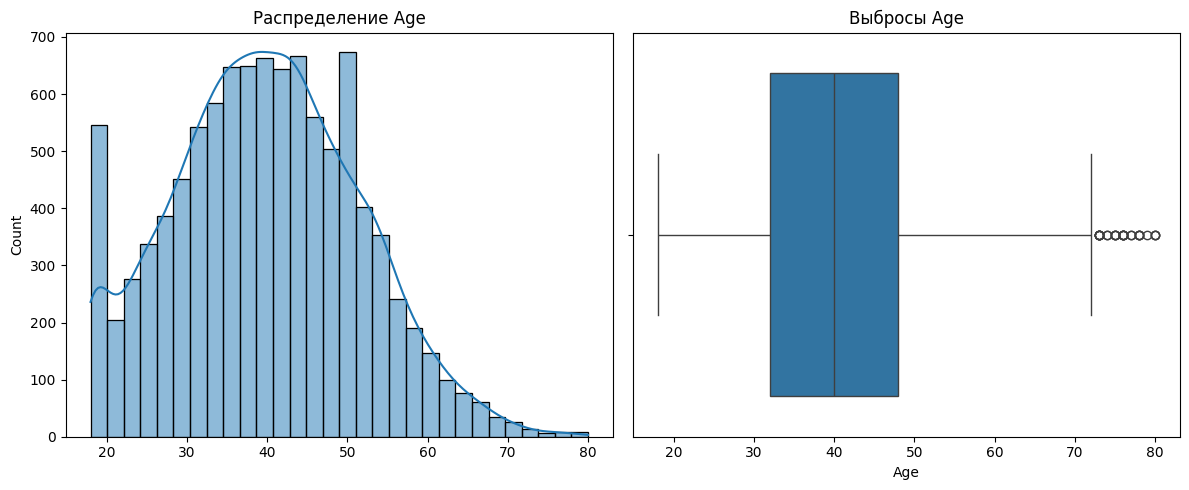

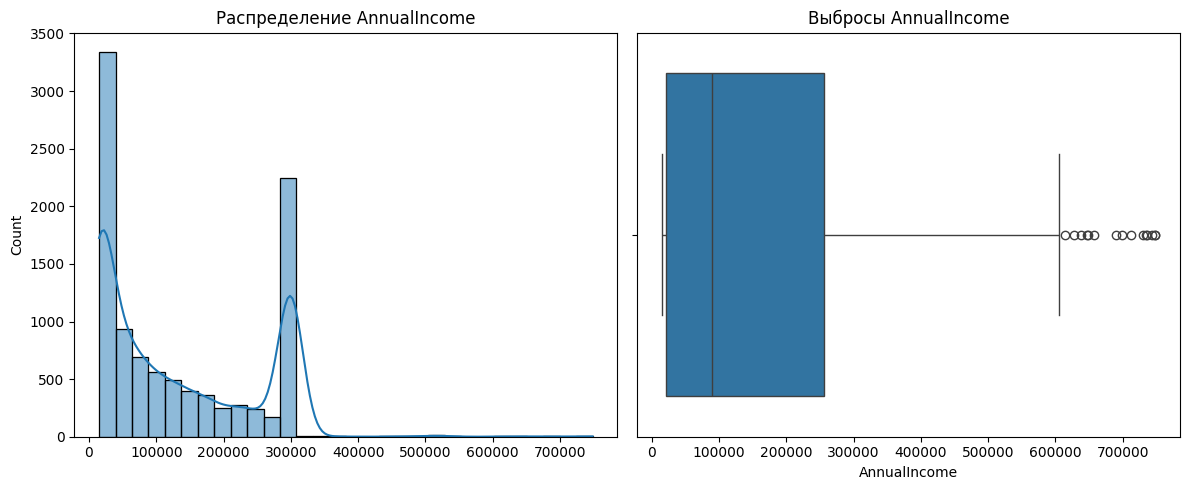

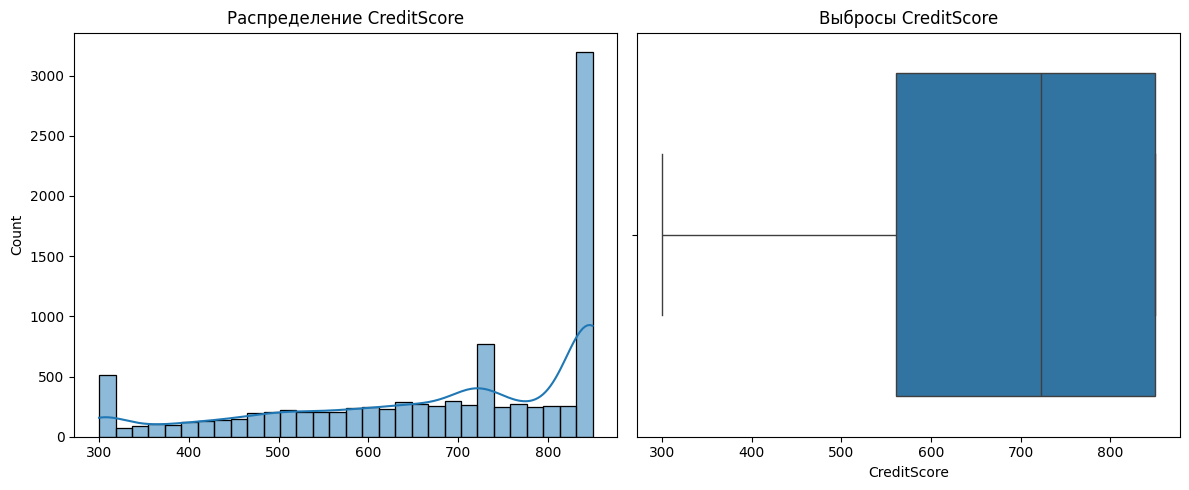

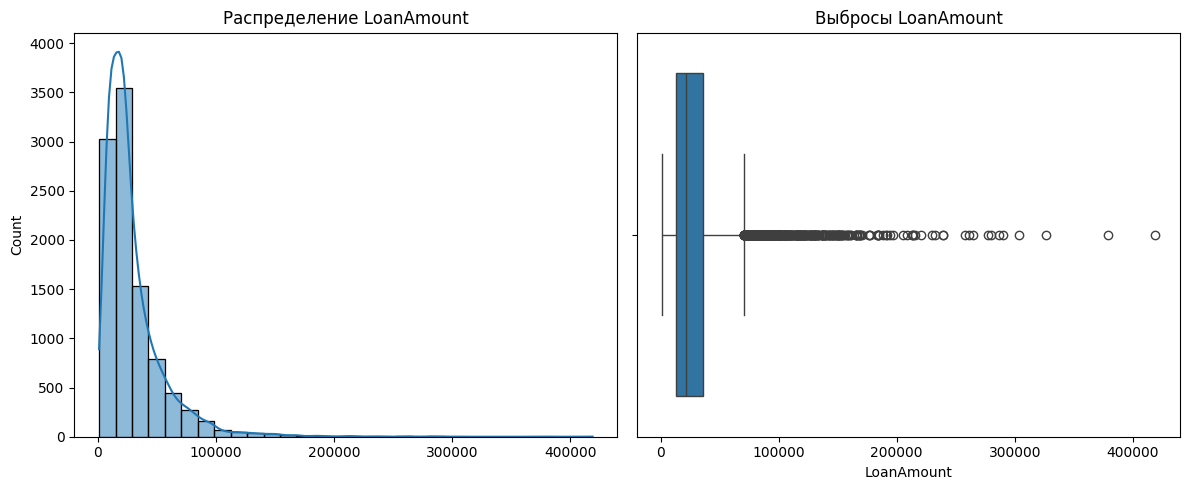

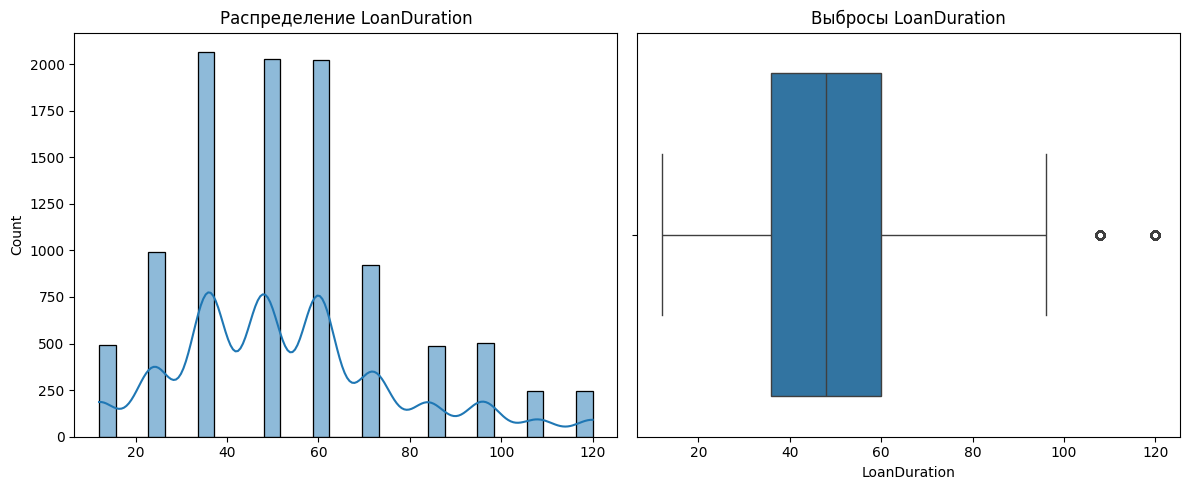

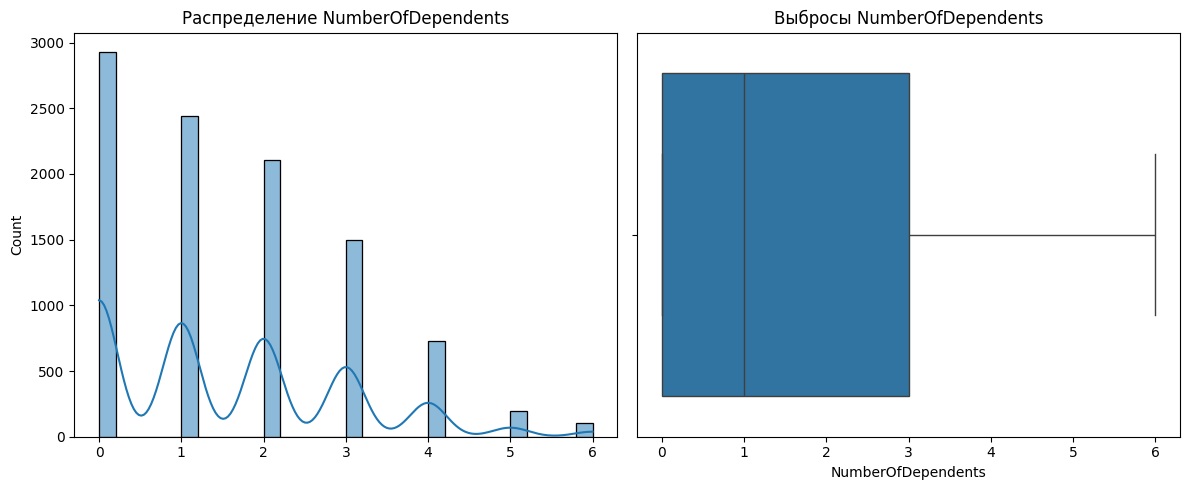

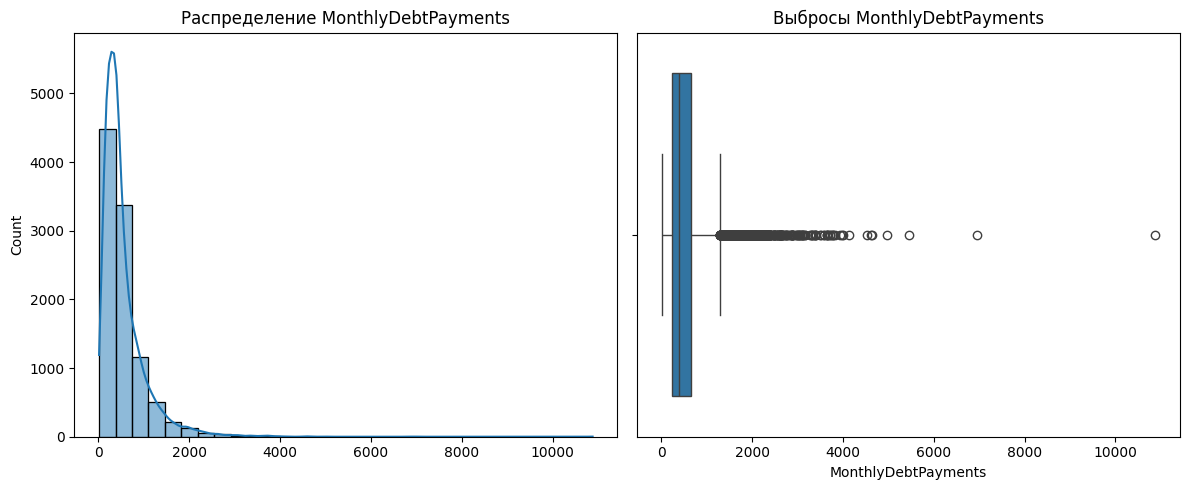

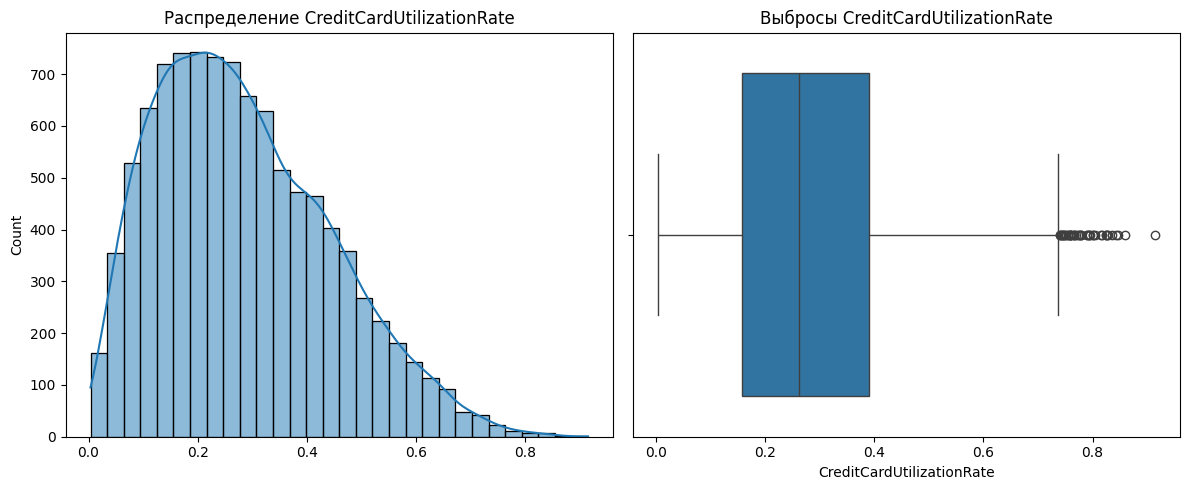

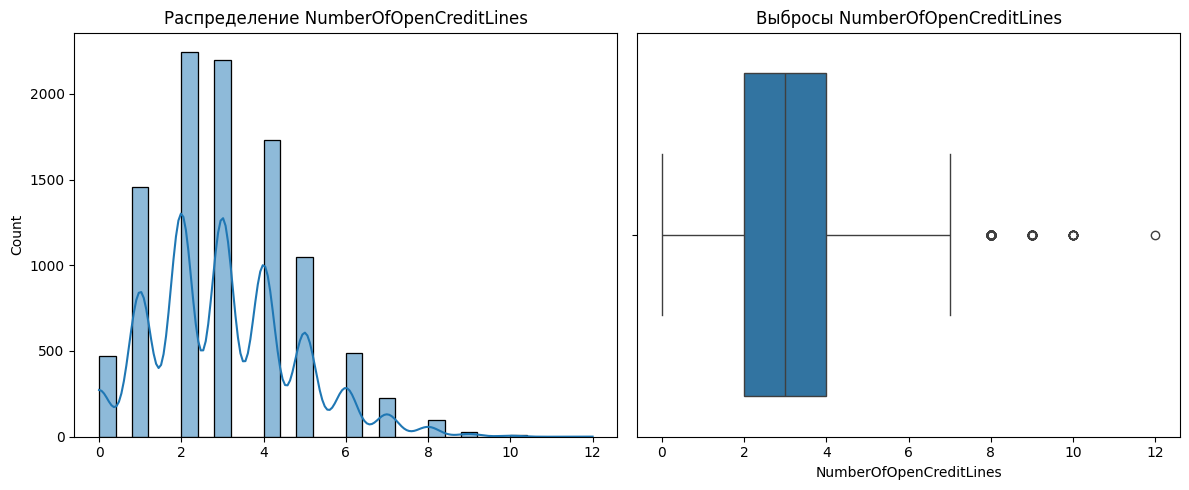

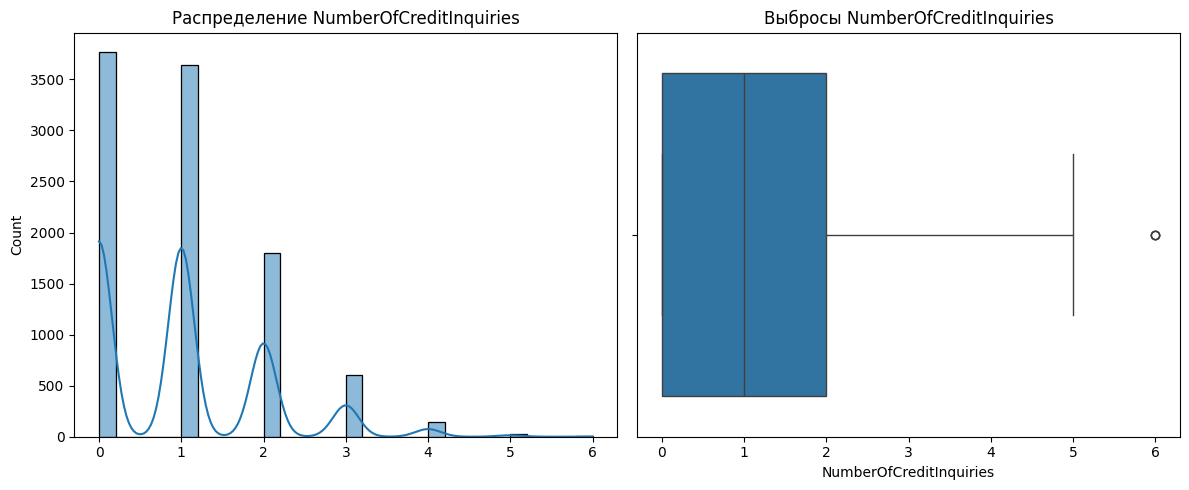

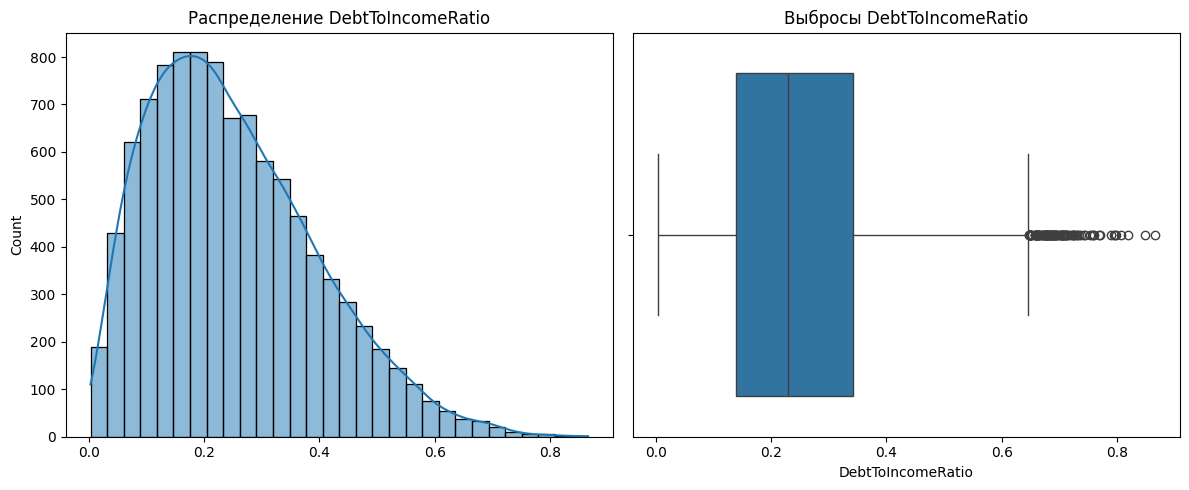

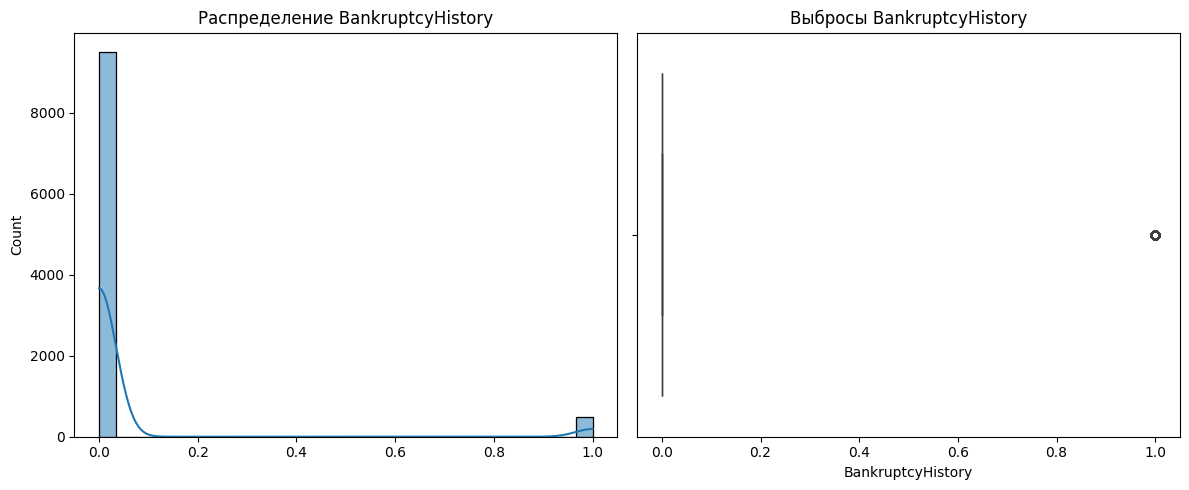

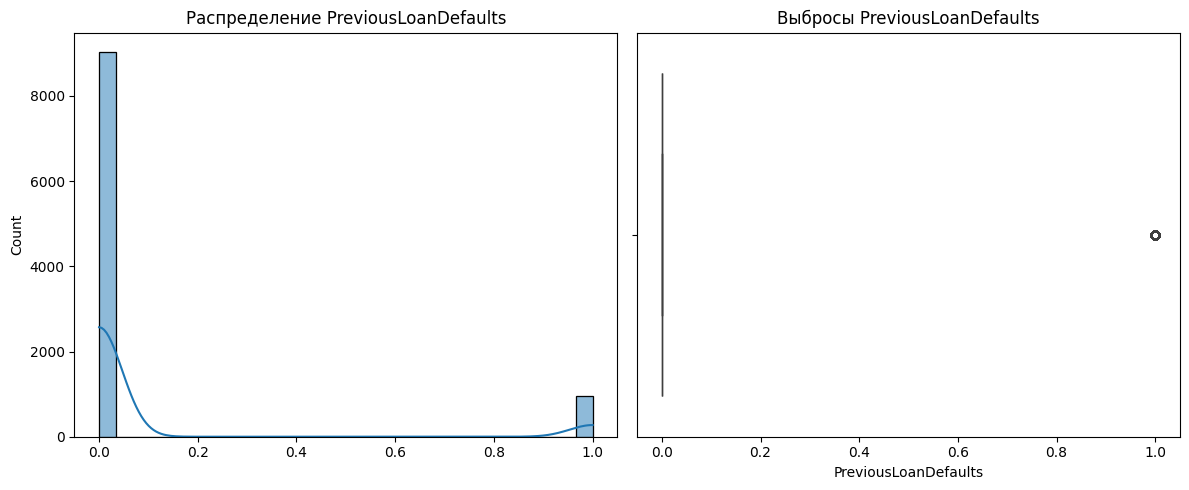

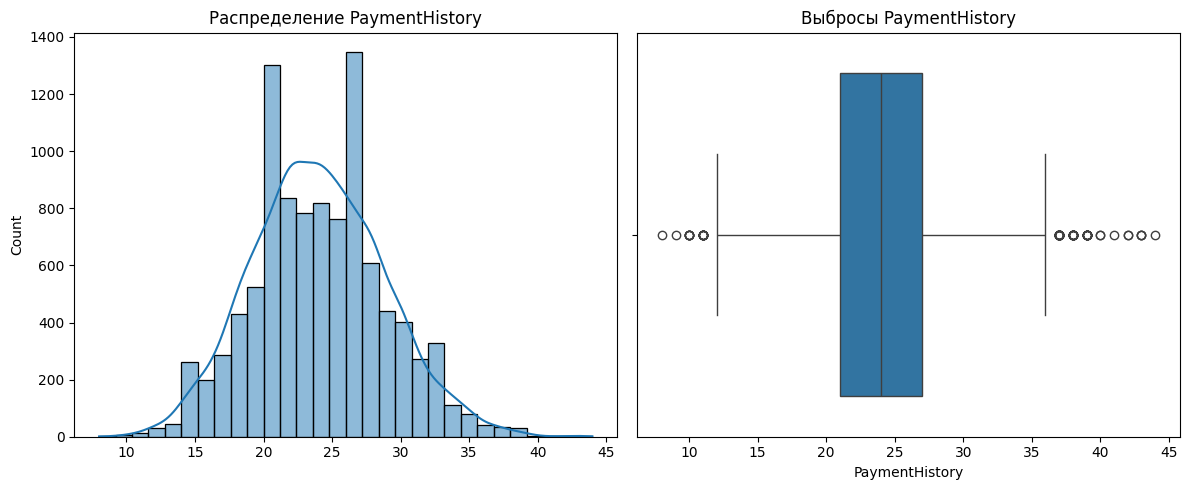

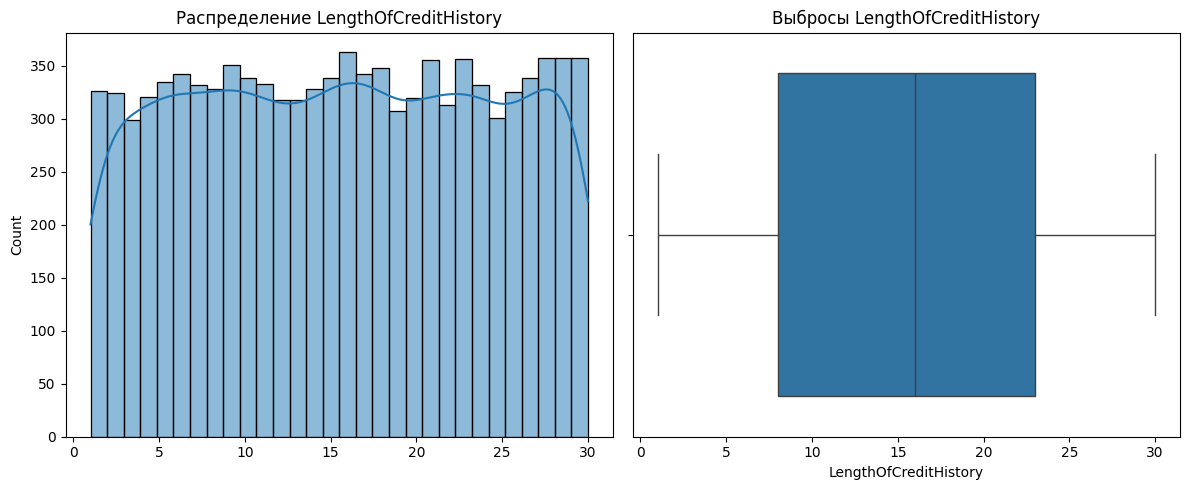

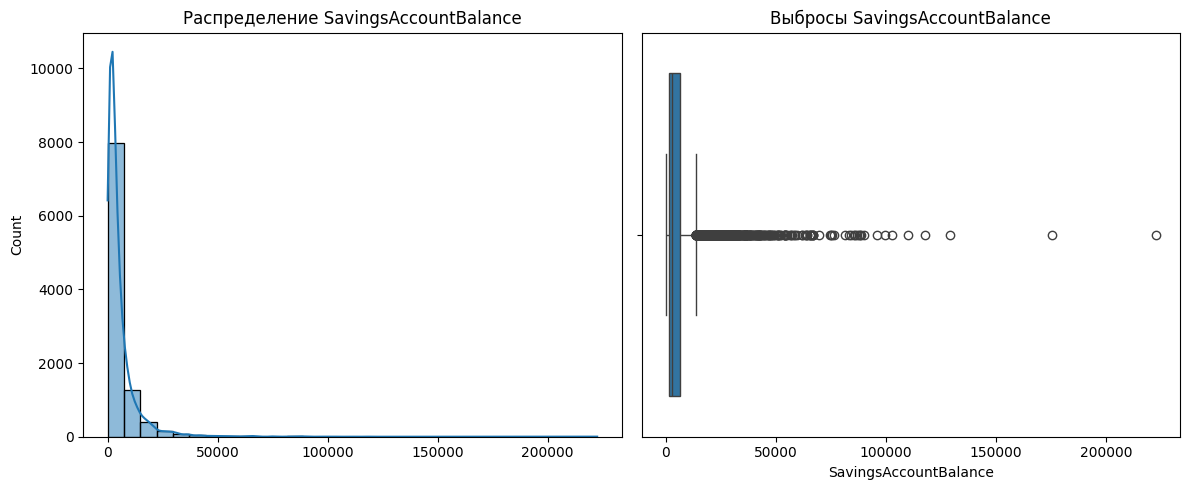

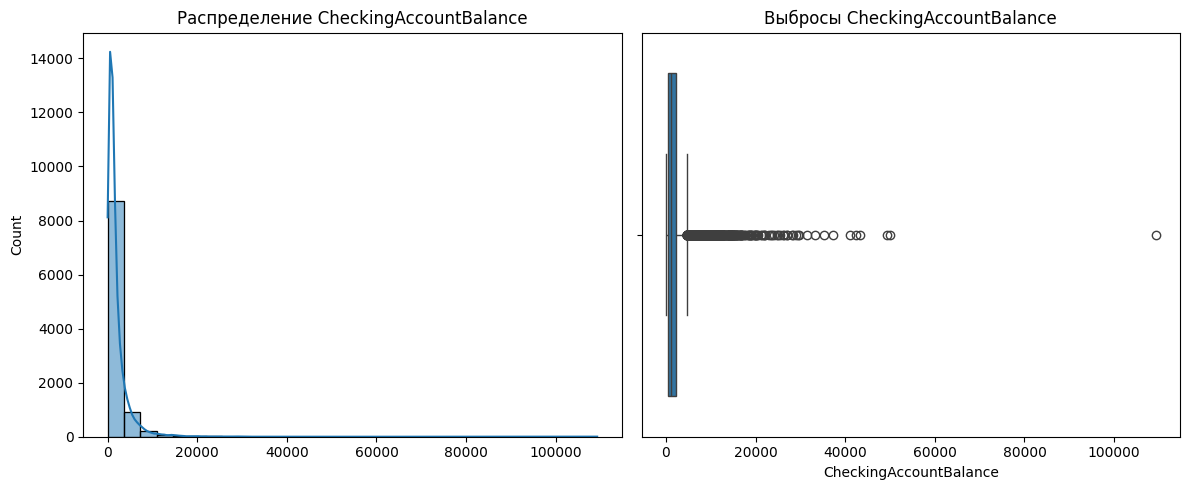

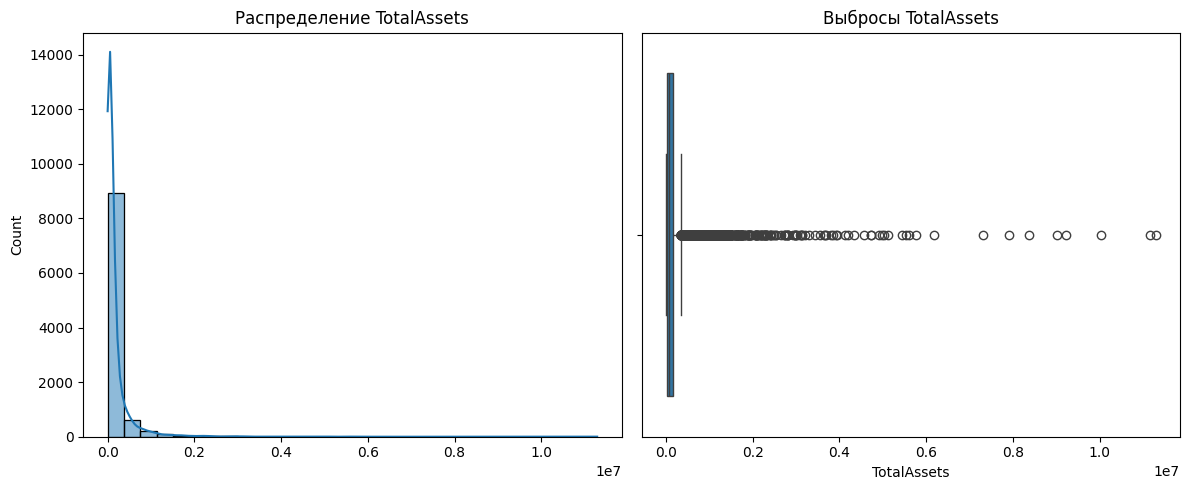

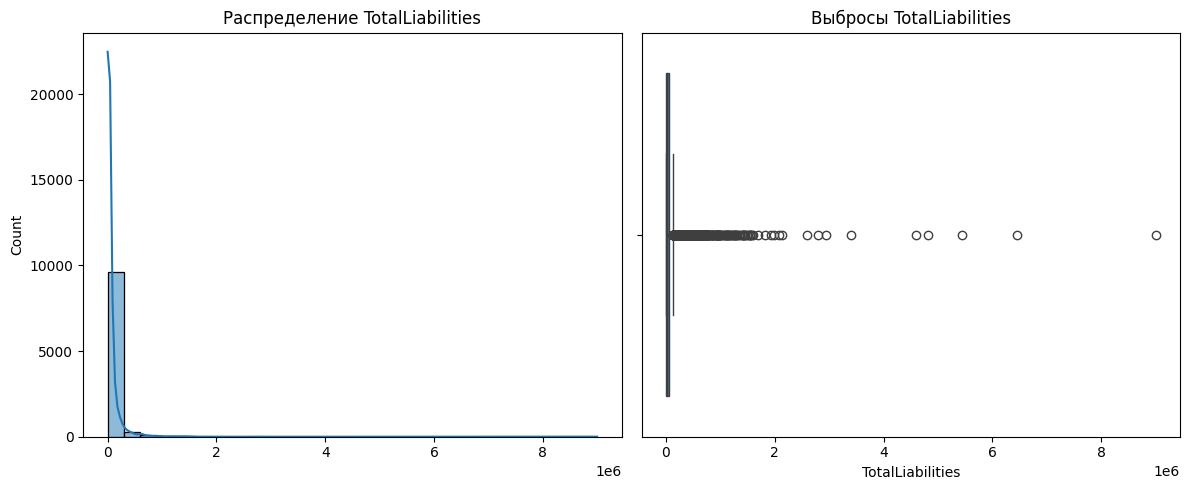

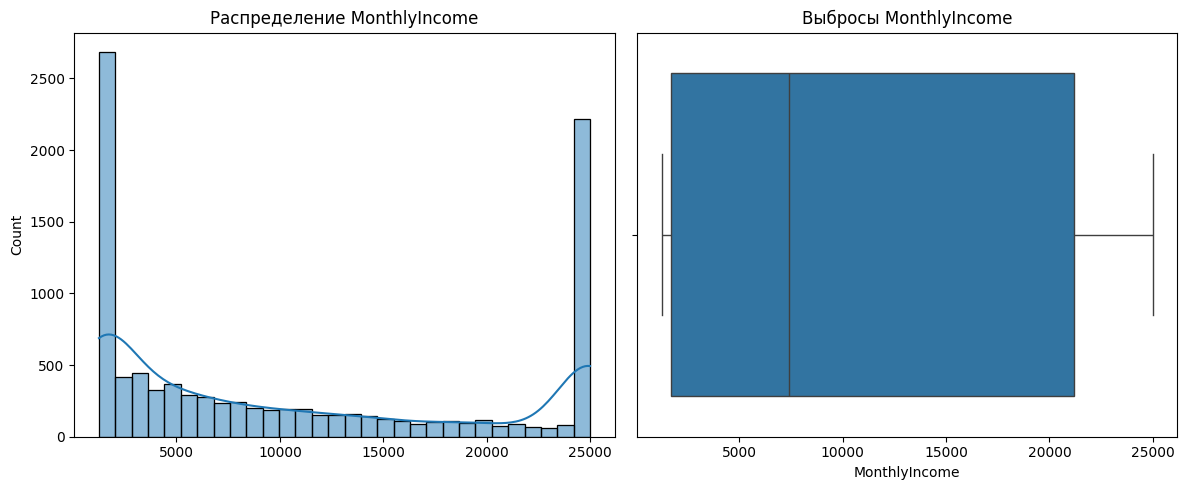

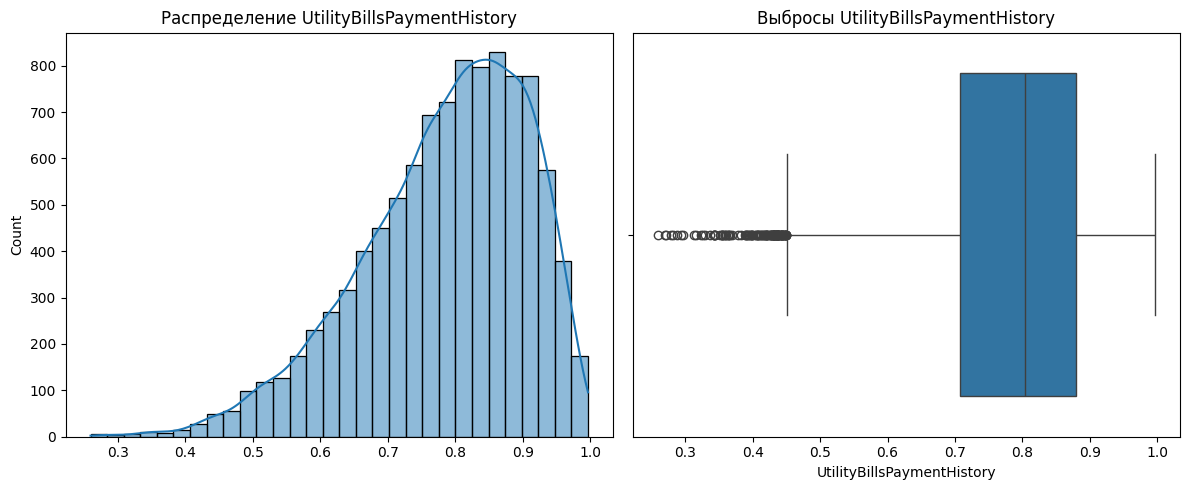

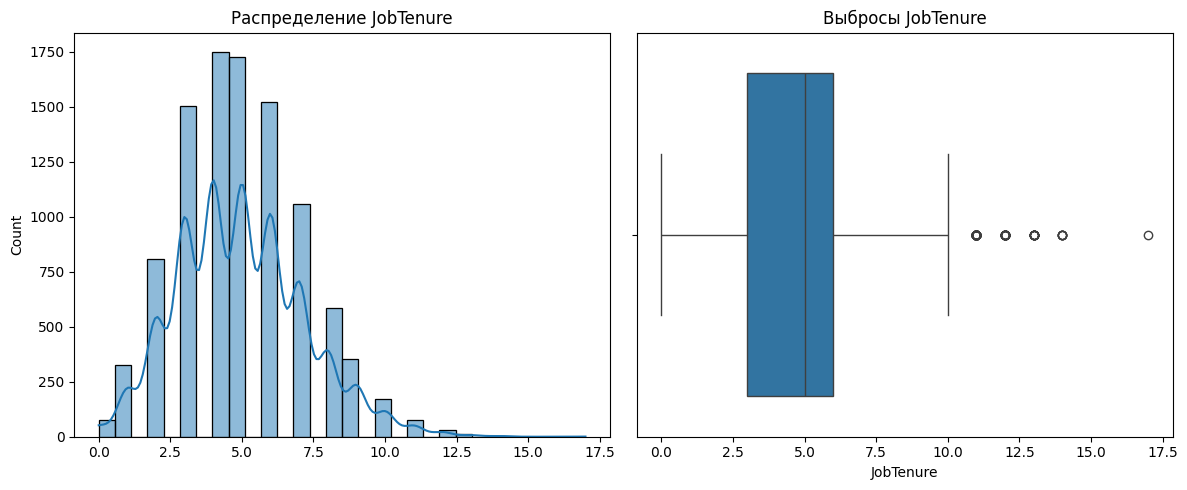

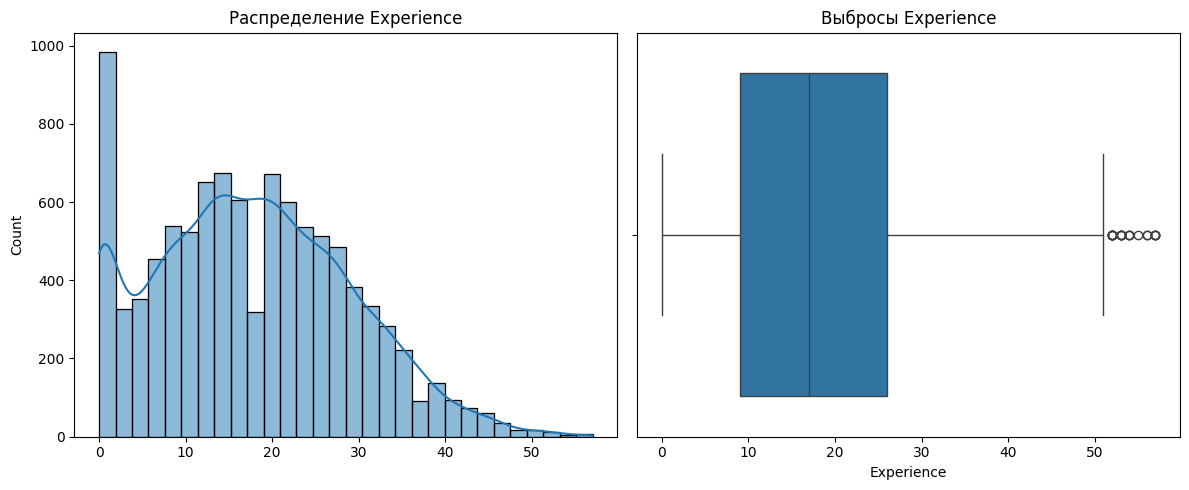

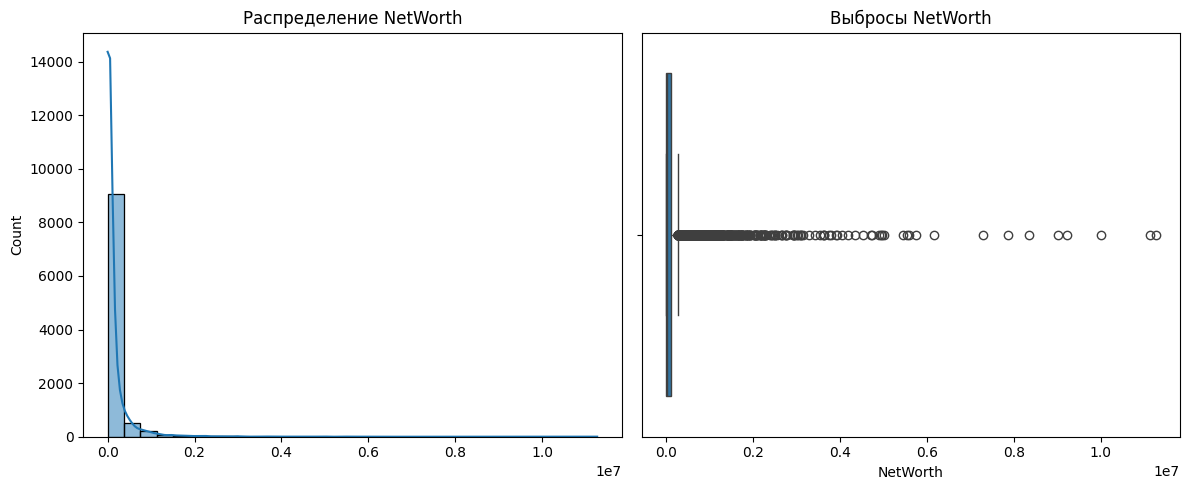

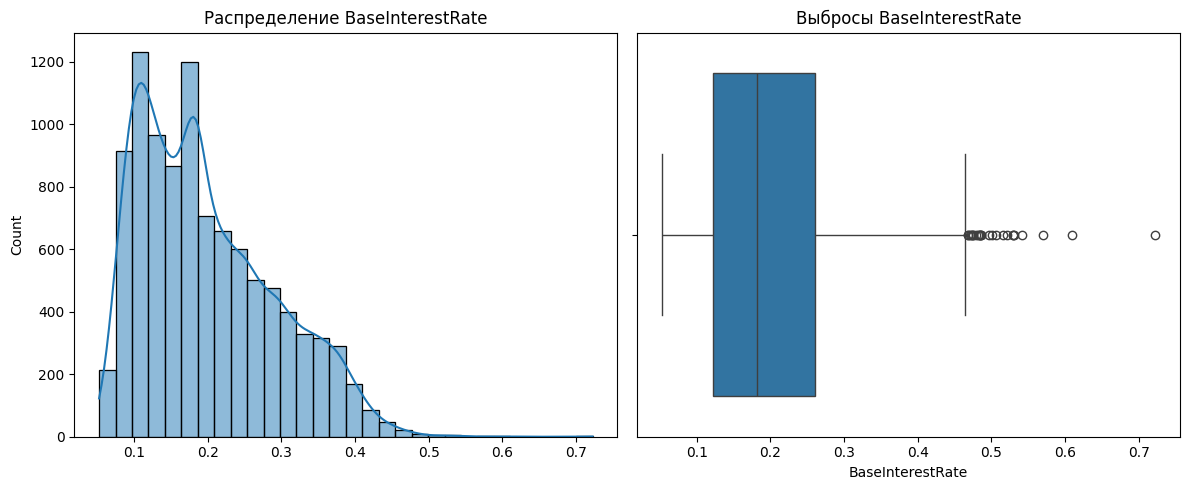

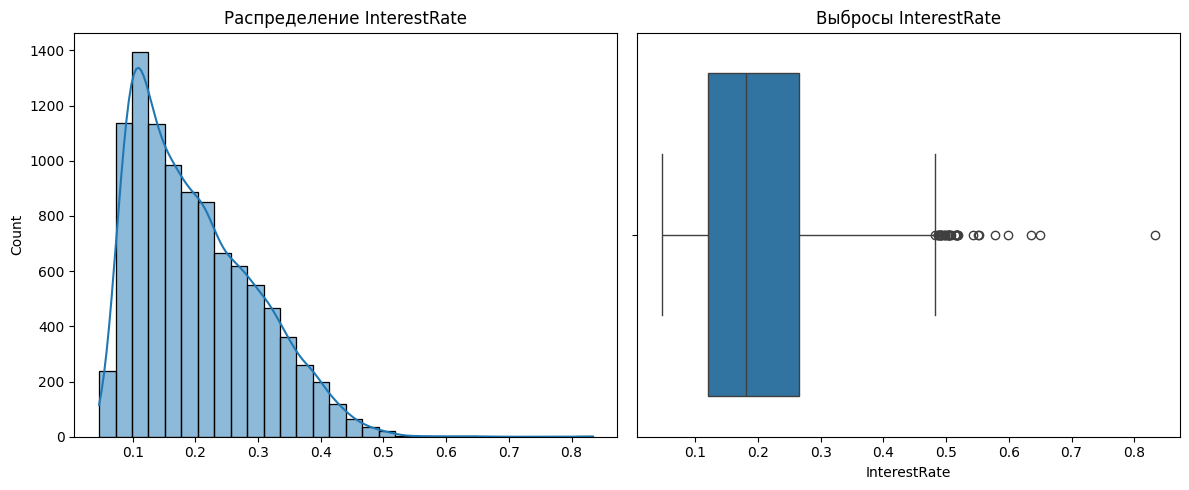

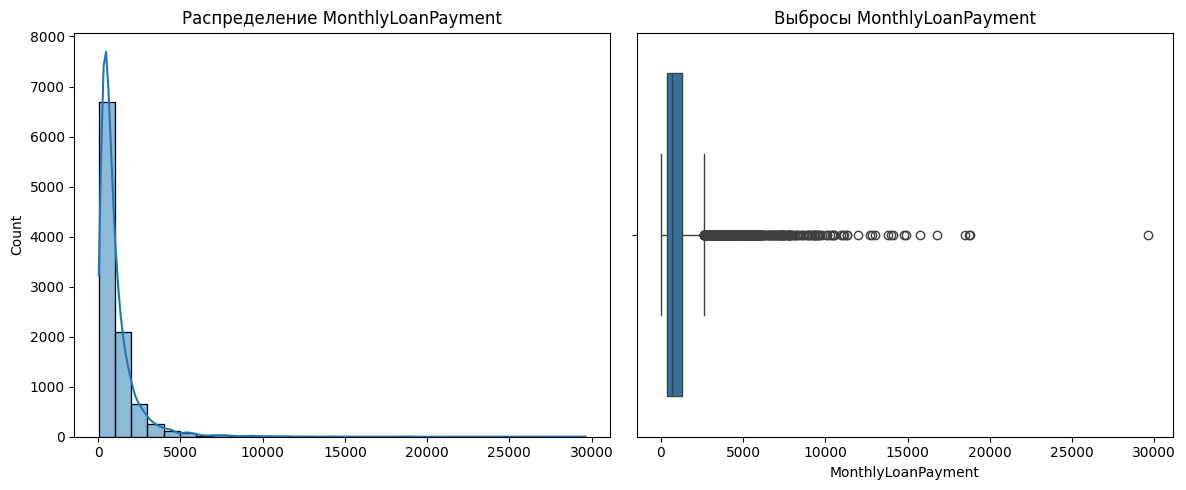

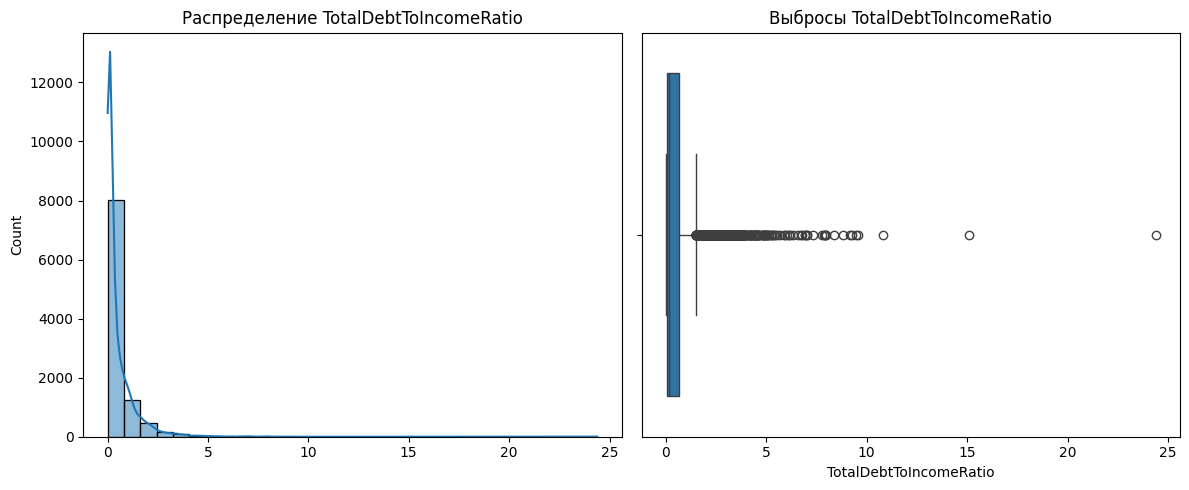

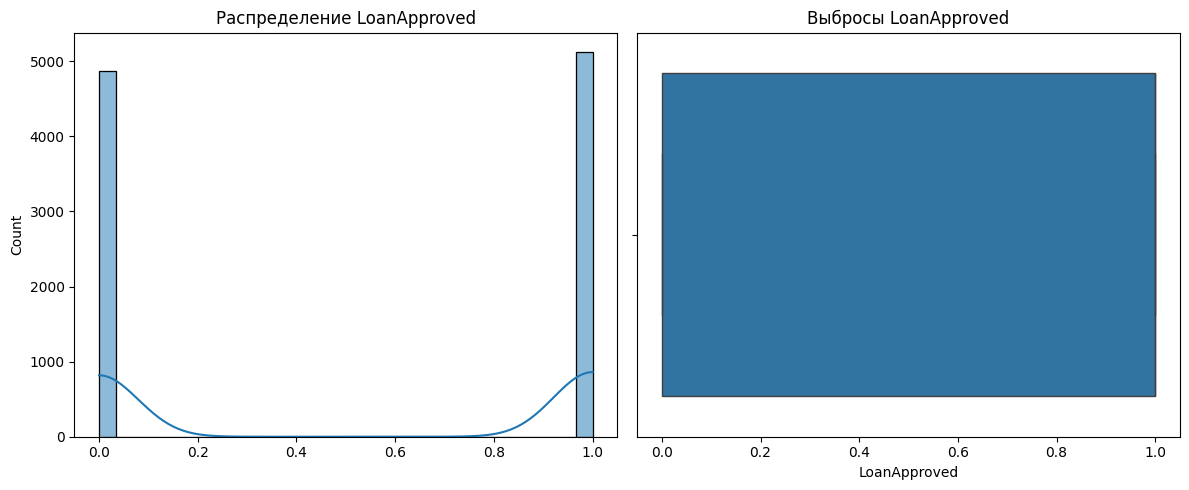

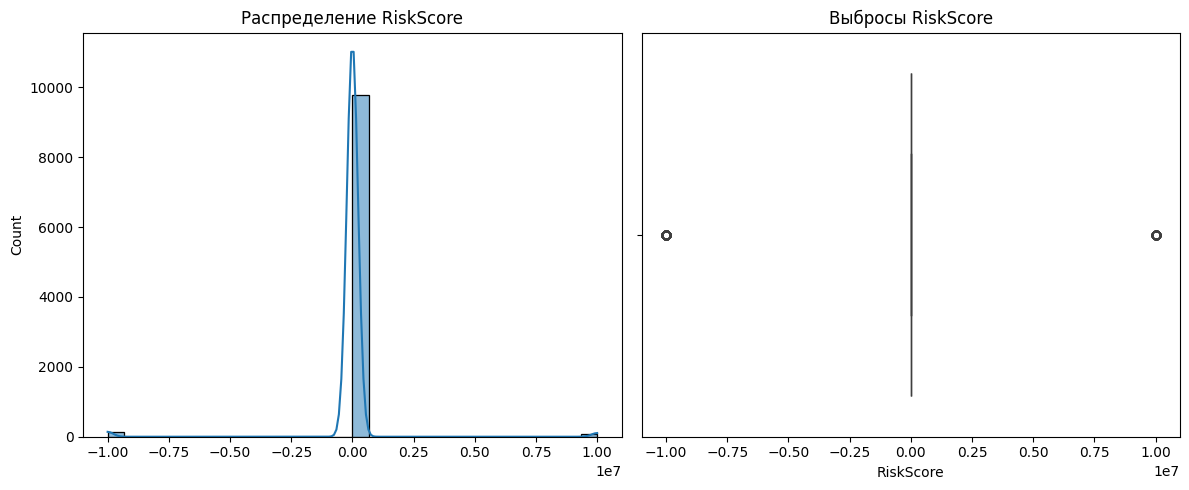

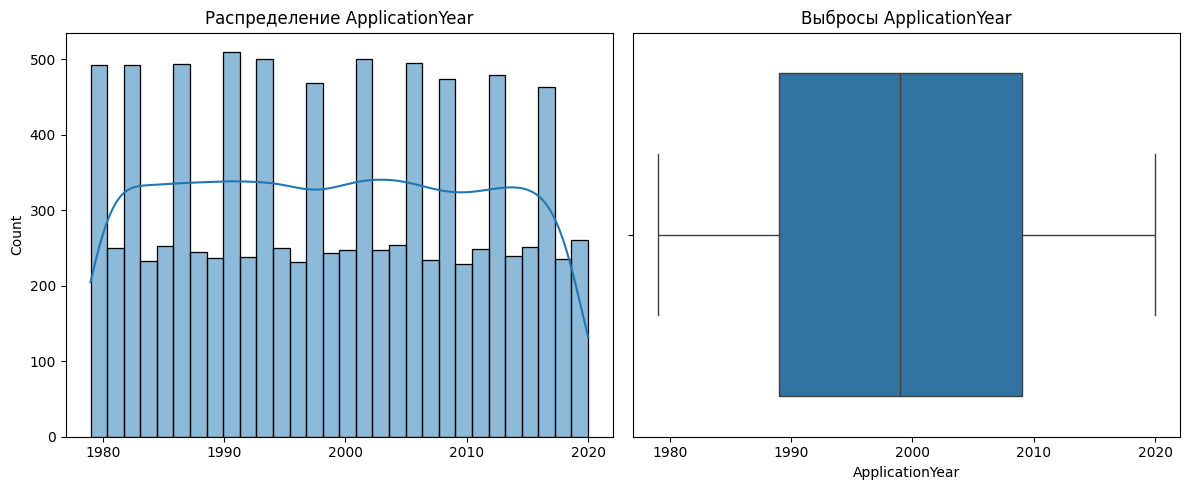

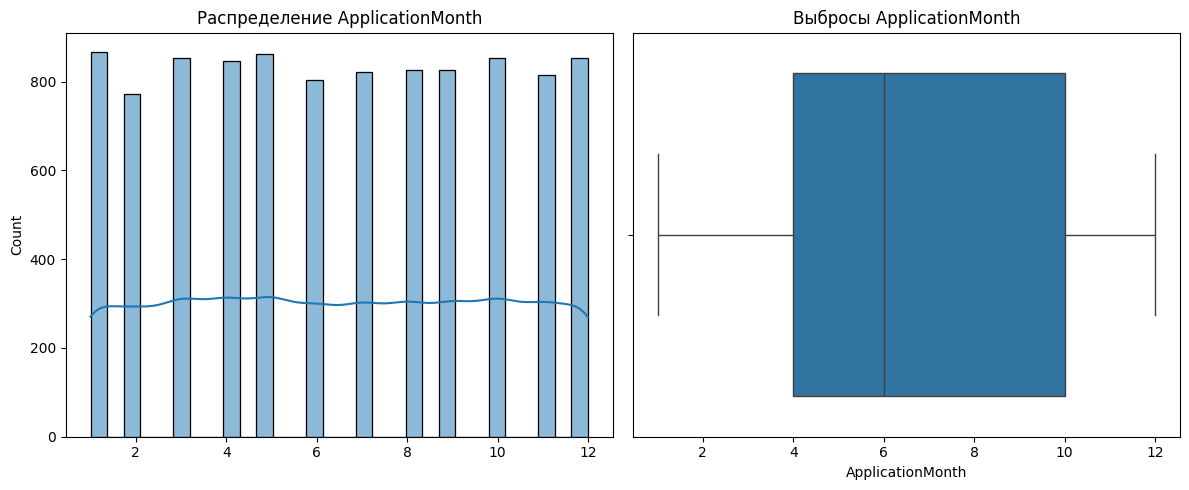

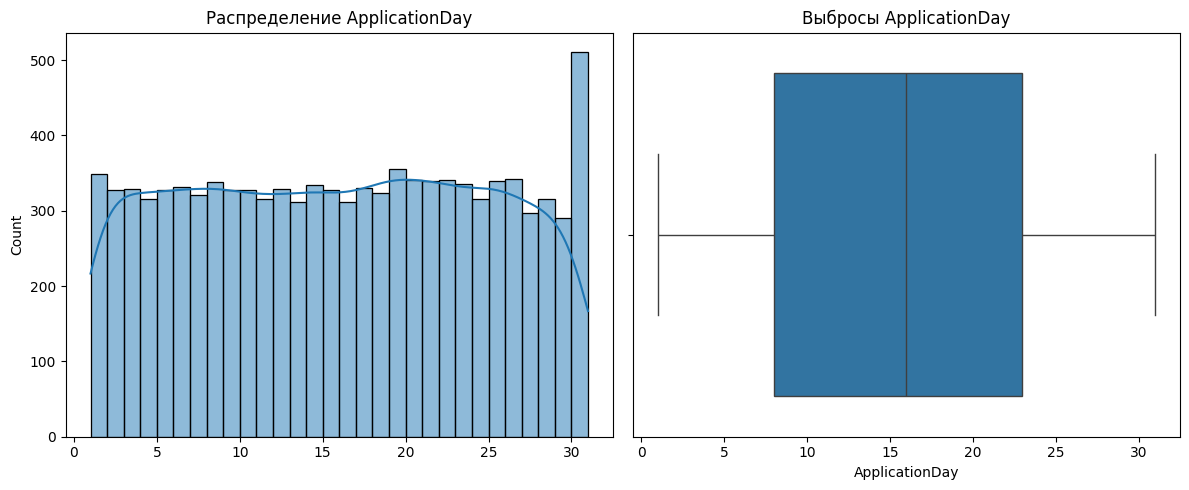

In [44]:
for col in numeric_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(prepared_train[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')
    plt.xlabel('')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=prepared_train[col])
    plt.title(f'Выбросы {col}')

    plt.tight_layout()
    plt.show()

Таргет имеет выбросы, которые надо будет отбросить для дальнейшего моделирования.

Заметим также, что многие признаки можно приблизить к нормальному распределению логарифмическим преобразование и тем самым избавиться от выбросов.

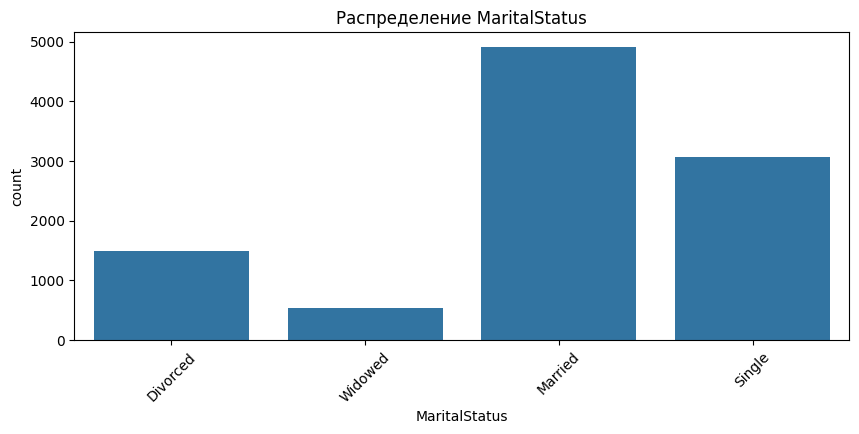

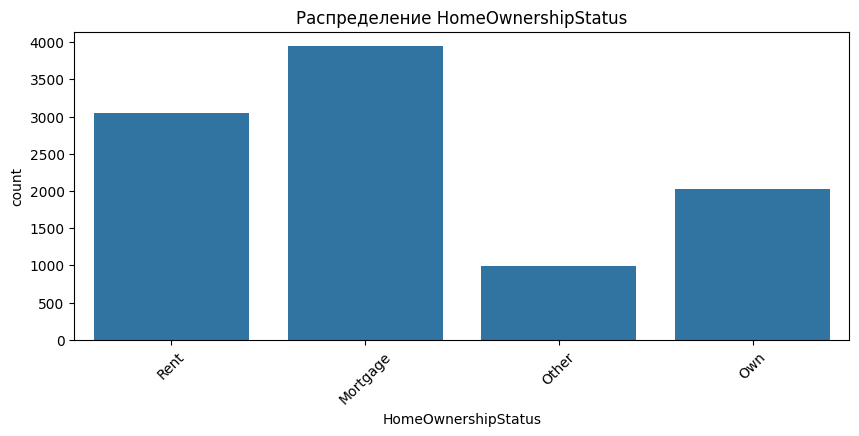

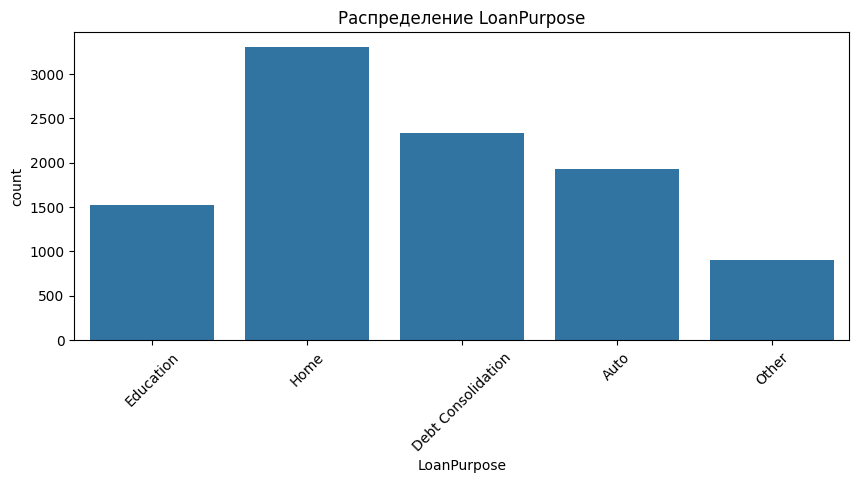

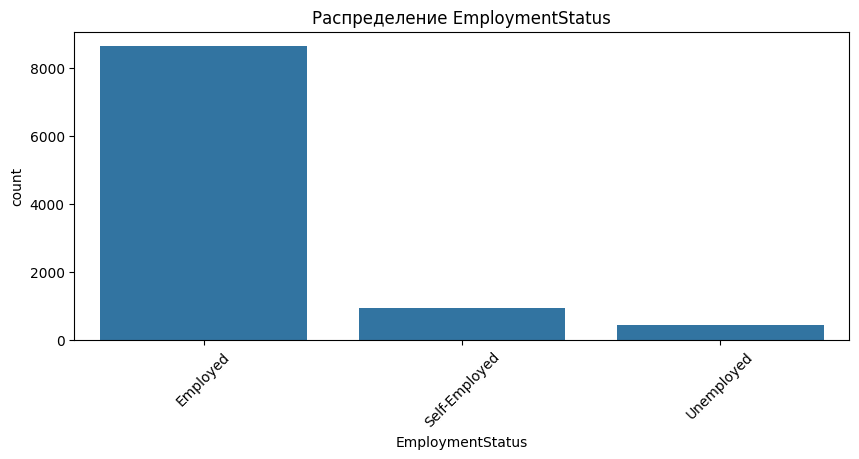

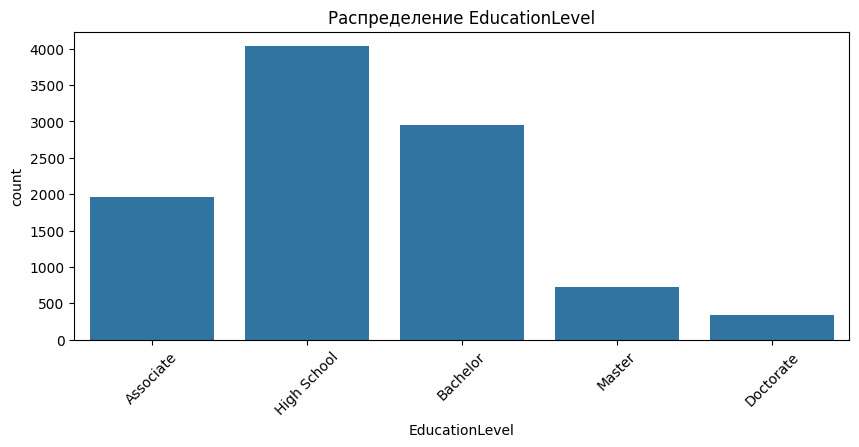

In [45]:
for col in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=prepared_train, x=col)
    plt.xticks(rotation=45)
    plt.title(f'Распределение {col}')
    plt.show()

Категорий мало, поэтому будем использовать `One-Hot` кодирование.

In [46]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (data < lower_bound) | (data > upper_bound)

    return data[outliers_mask].count()

def remove_outliers_iqr(df, col):
    data = df[col]

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (data < lower_bound) | (data > upper_bound)

    return df.copy()[~outliers_mask].reset_index(drop=True)

Посмотрим на графики связи численных признаков с таргетом.

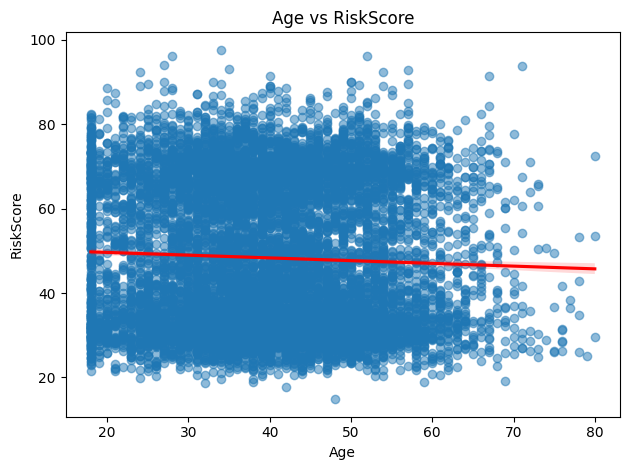

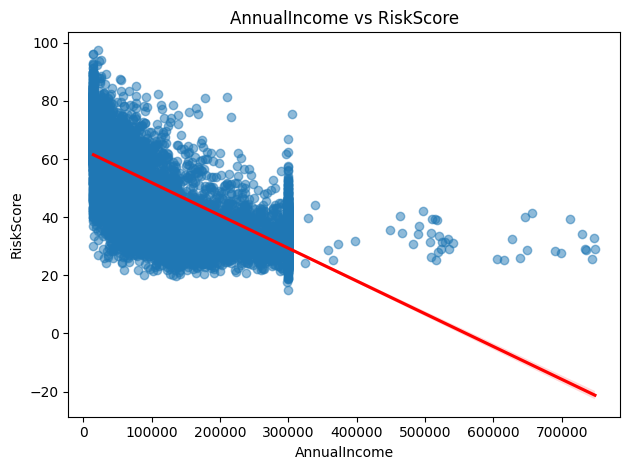

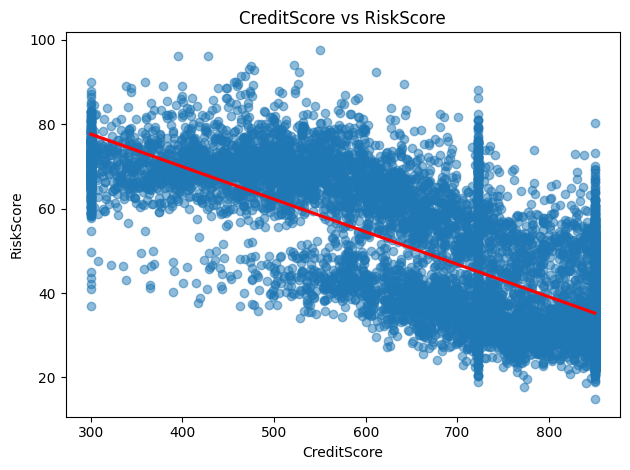

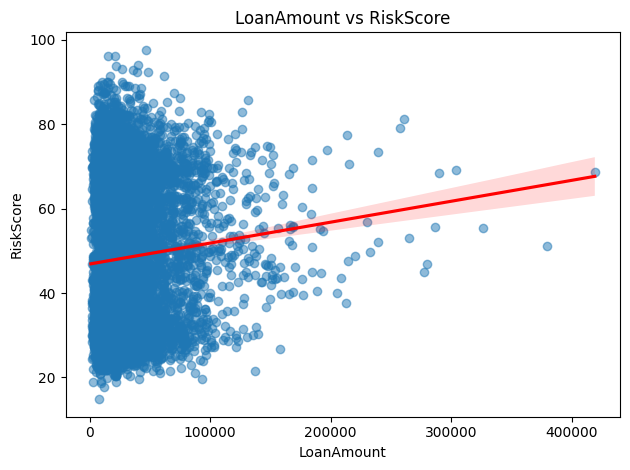

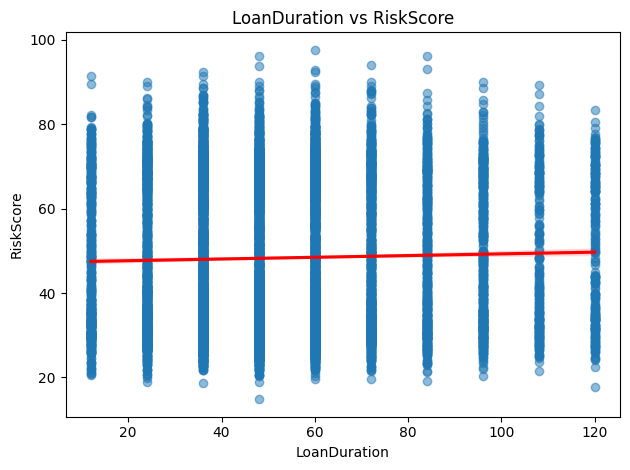

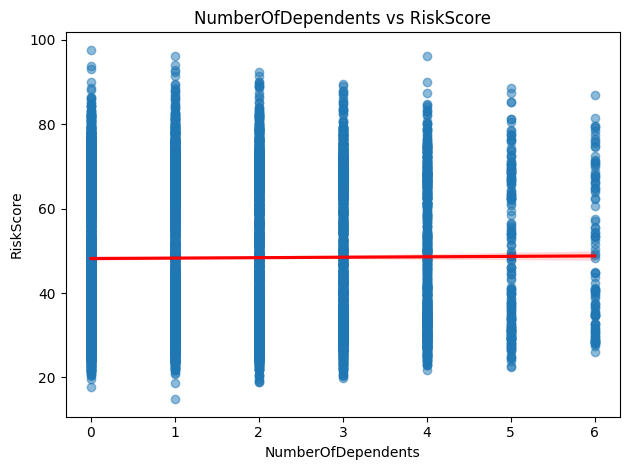

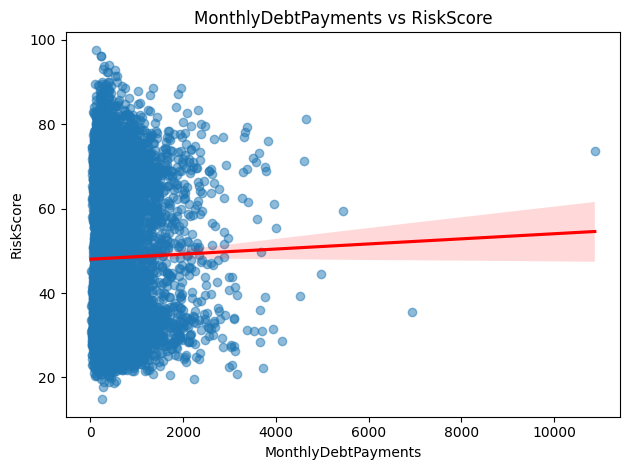

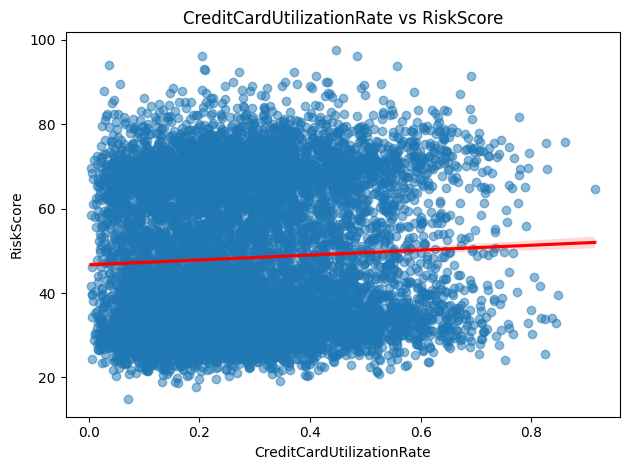

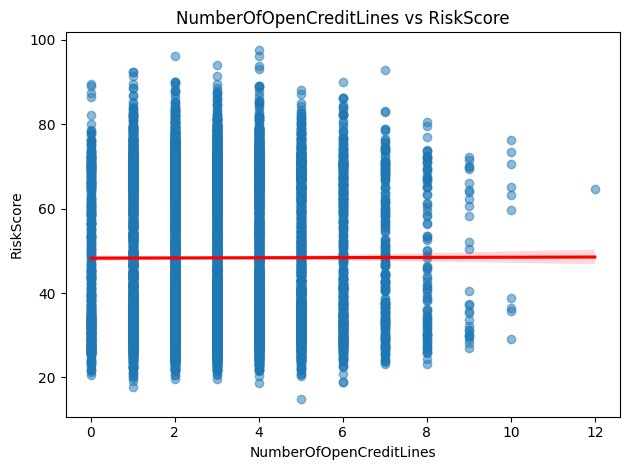

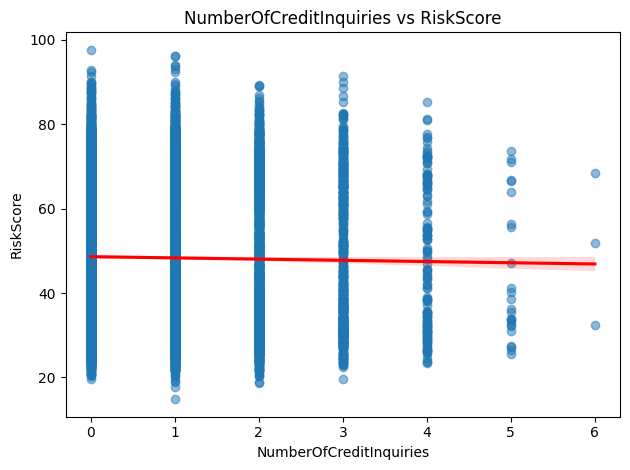

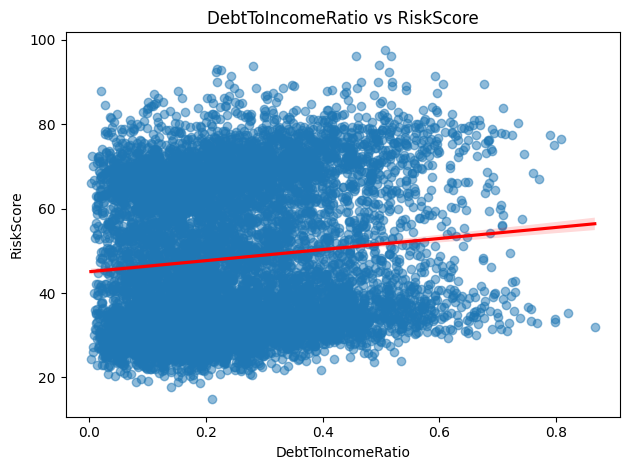

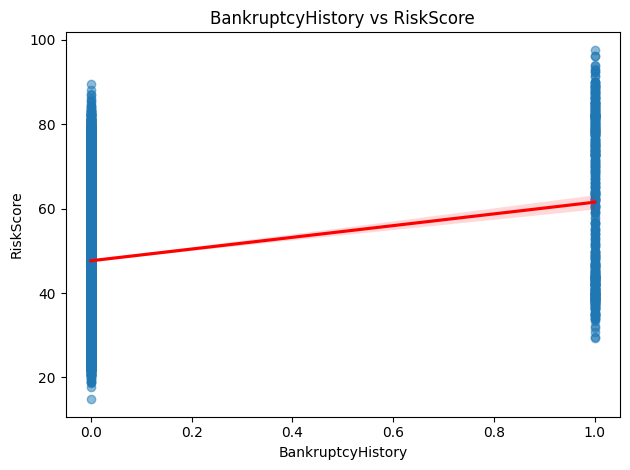

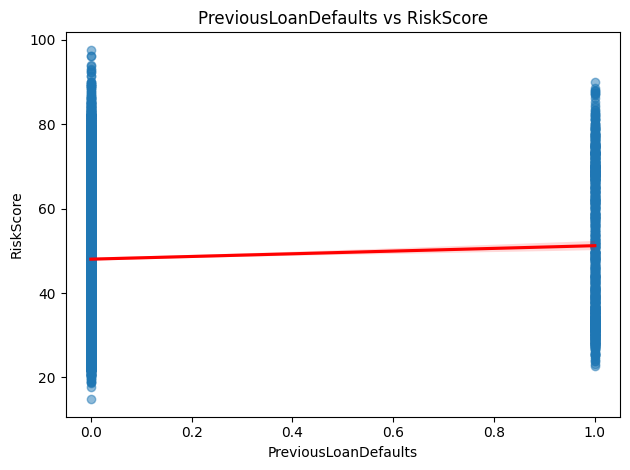

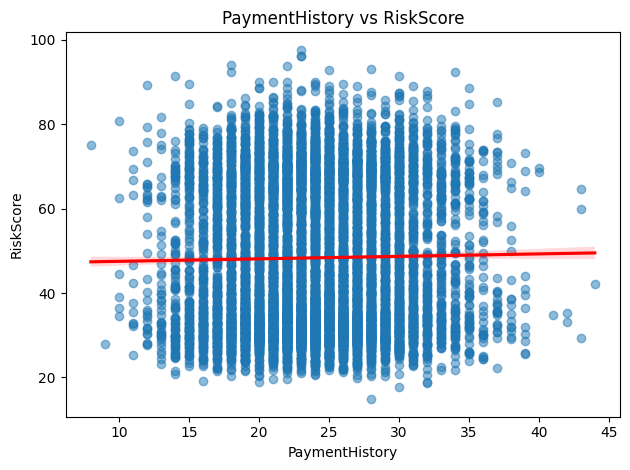

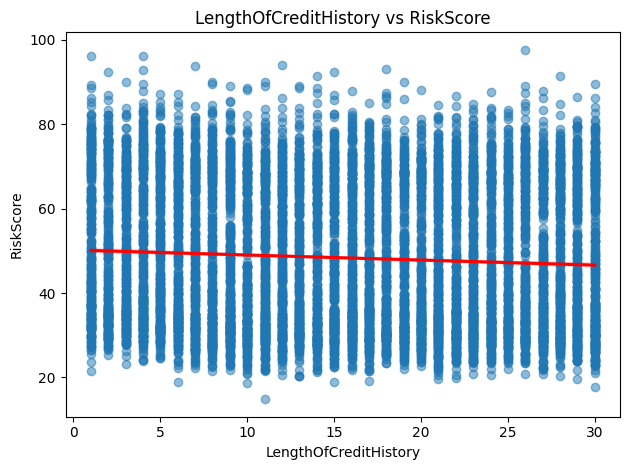

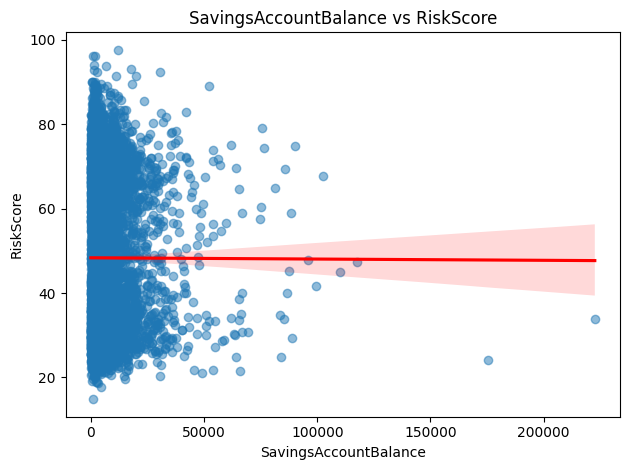

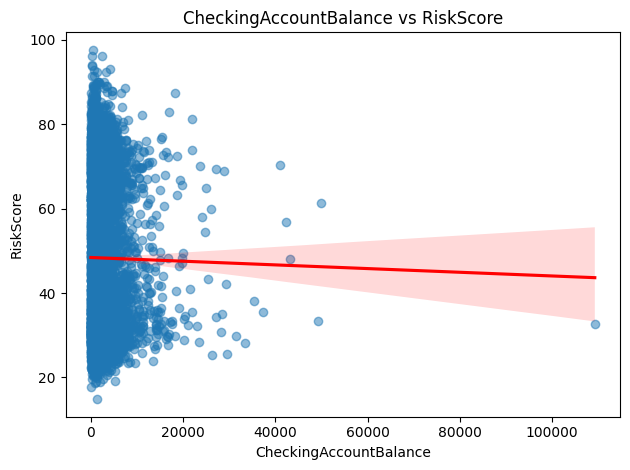

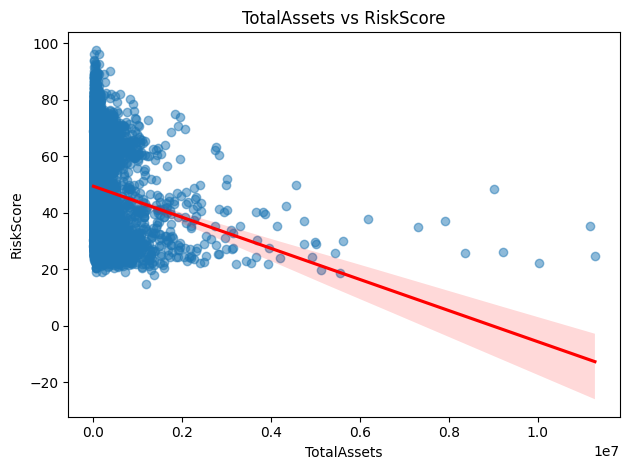

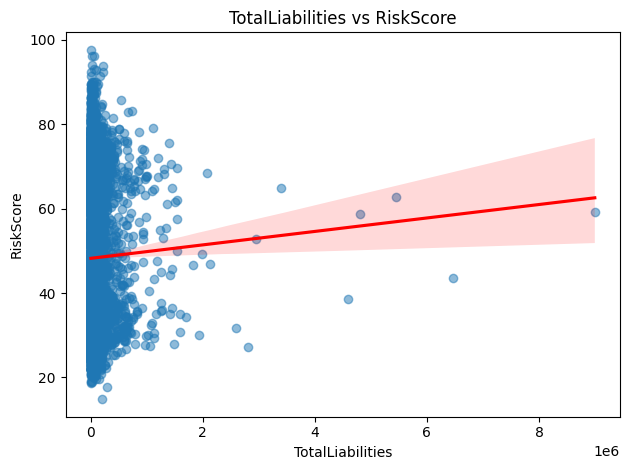

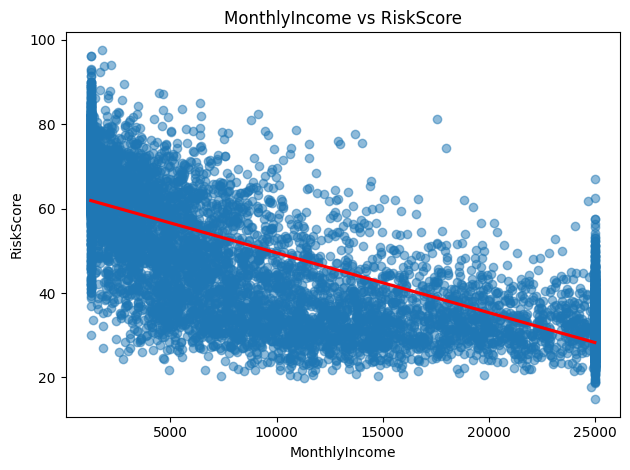

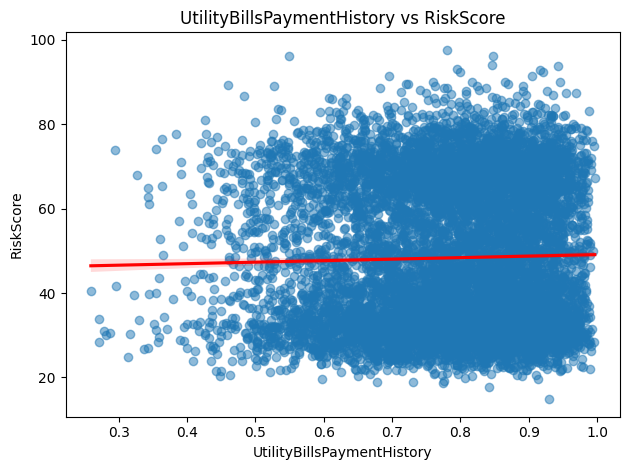

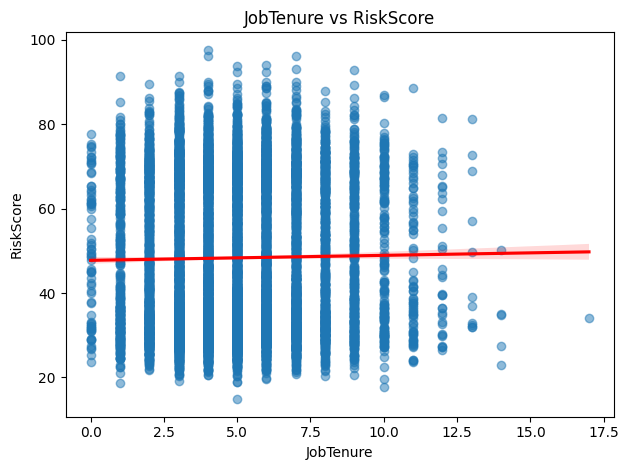

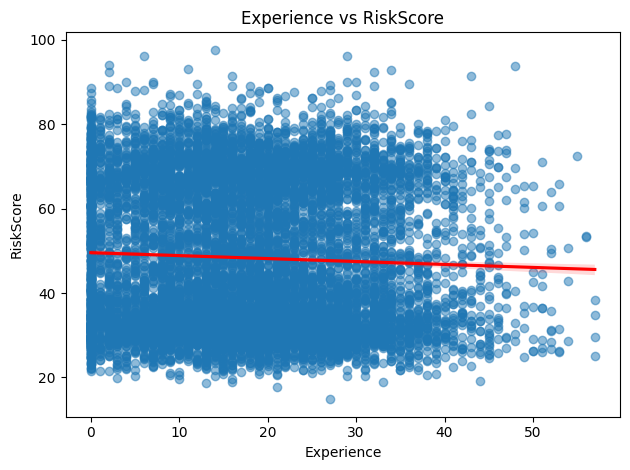

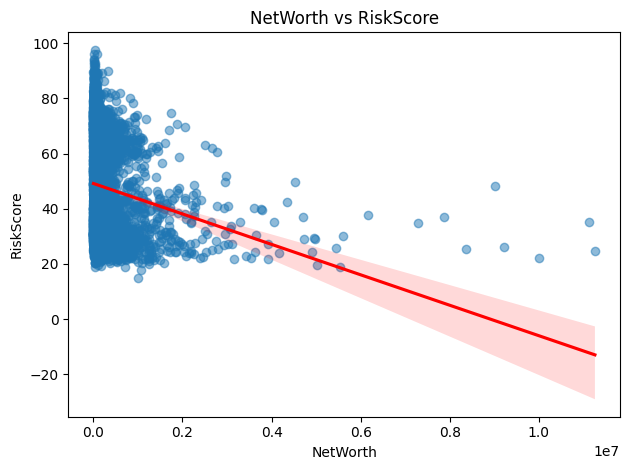

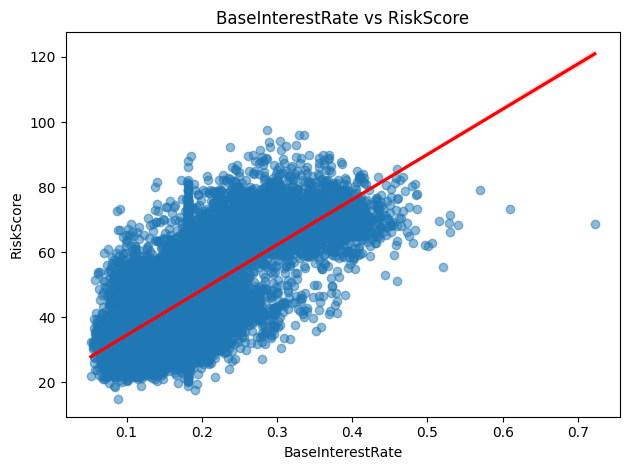

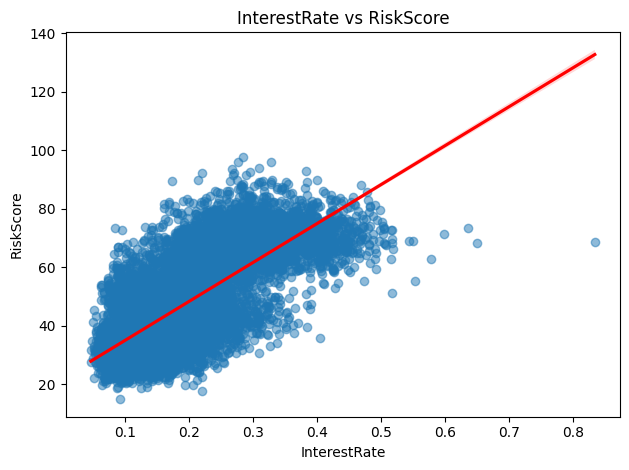

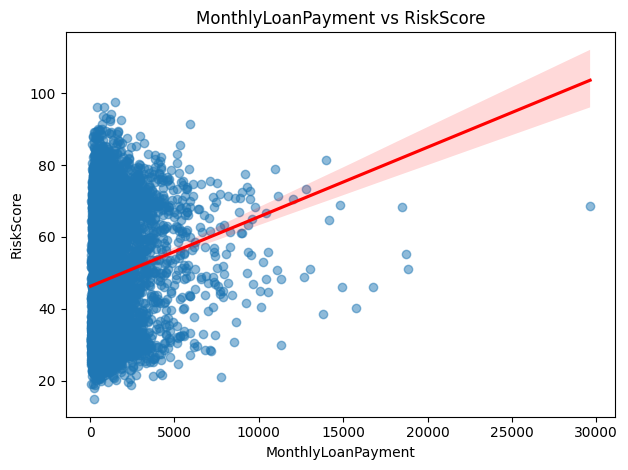

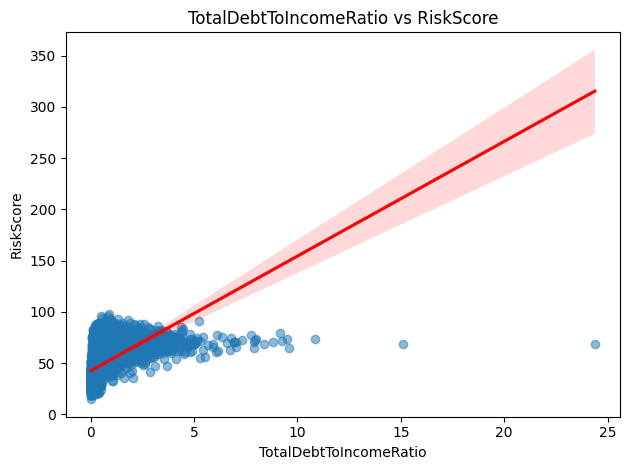

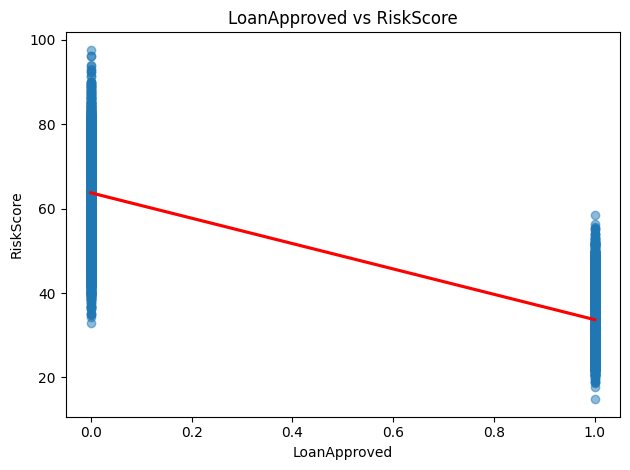

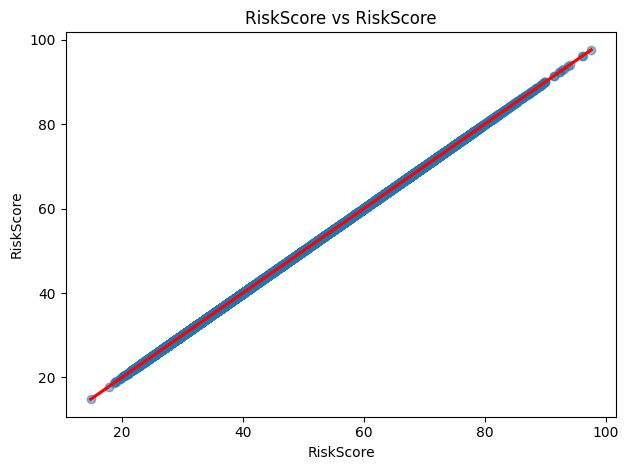

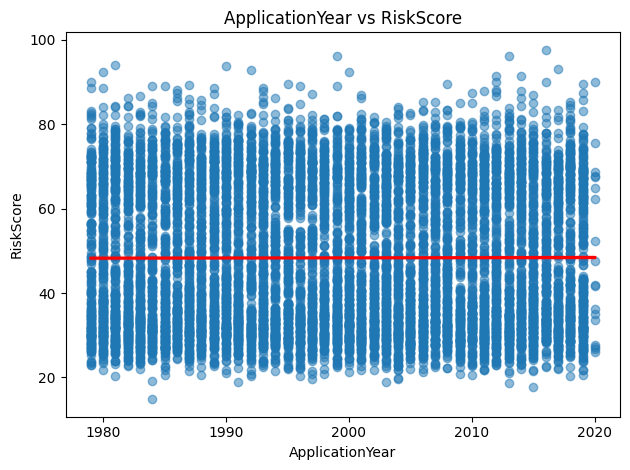

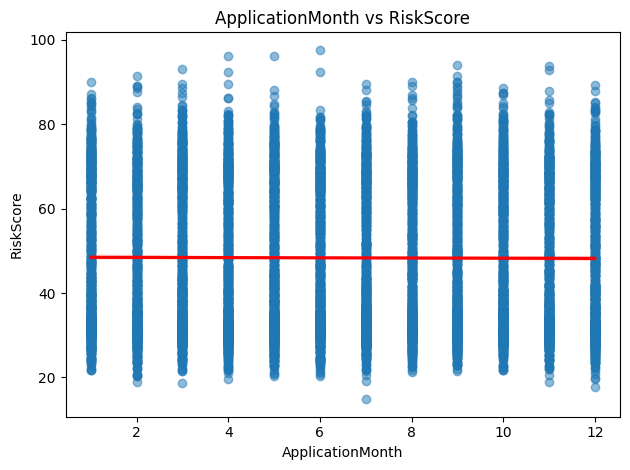

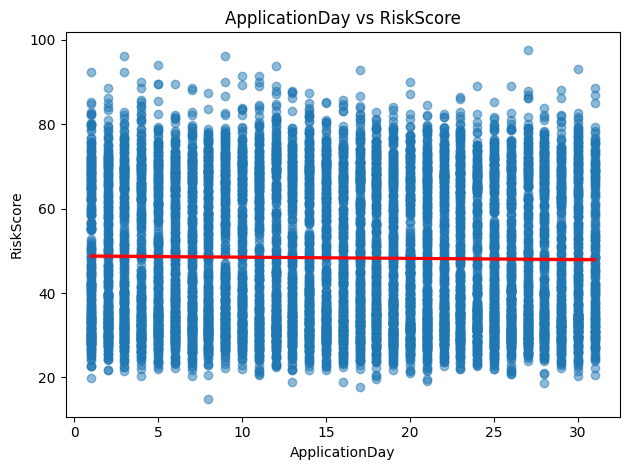

In [47]:
train_without_anomal_target = remove_outliers_iqr(prepared_train, 'RiskScore')

for col in numeric_features:
    sns.regplot(
        x=train_without_anomal_target[col],
        y=train_without_anomal_target['RiskScore'],
        scatter_kws={'alpha':0.5},
        line_kws={'color':'red'}
    )

    plt.title(f'{col} vs {"RiskScore"}')
    plt.xlabel(col)
    plt.ylabel('RiskScore')

    plt.tight_layout()
    plt.show()

Большинство признаков не имеют линейной связи с `RiskScore`, поэтому добавим осмысленные комбинации и преобразования имеющихся признаков в качестве новых.

Посмотрим на распределение таргета в зависимости от значений категориальных переменных.

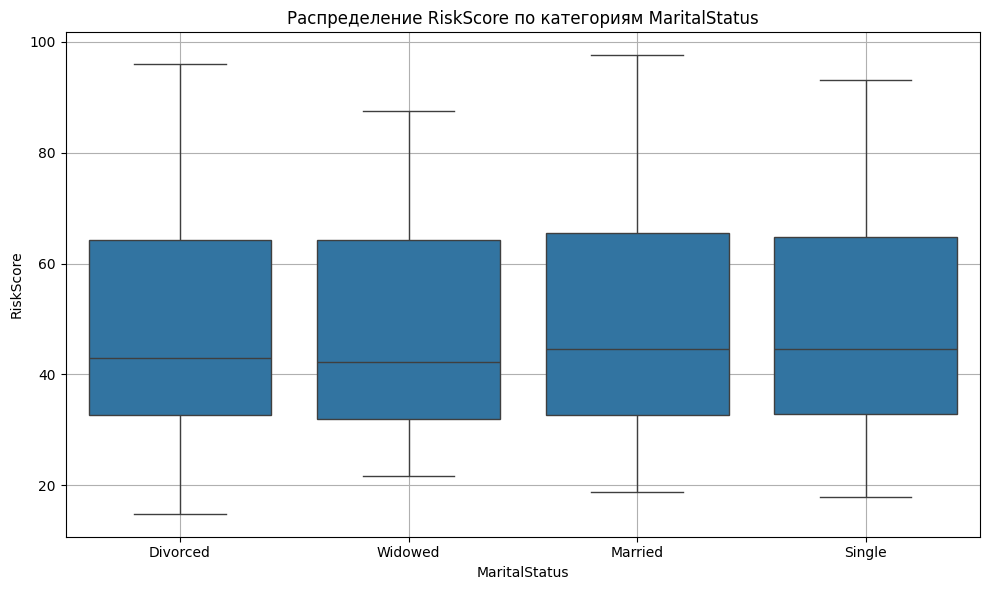

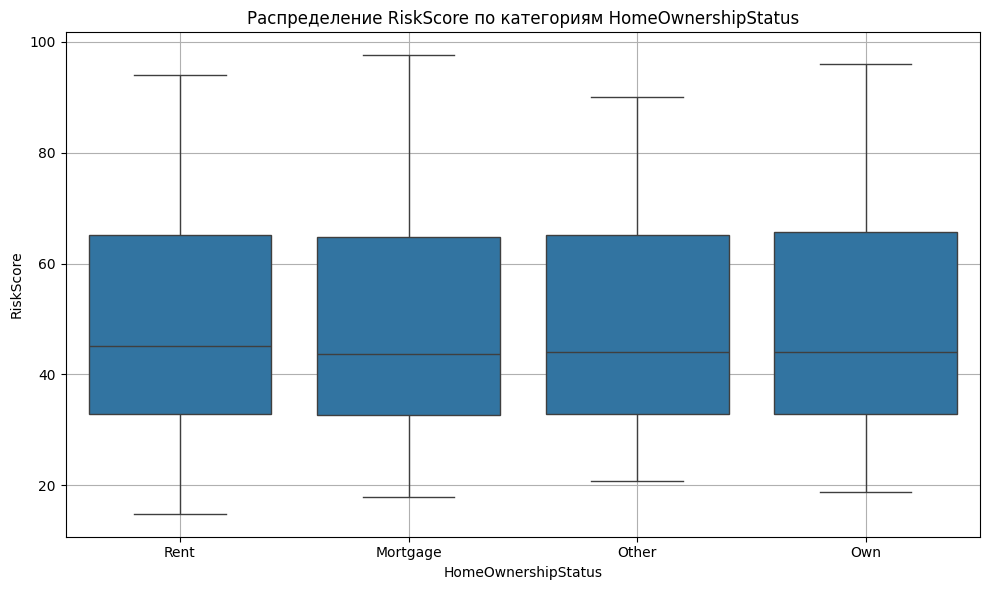

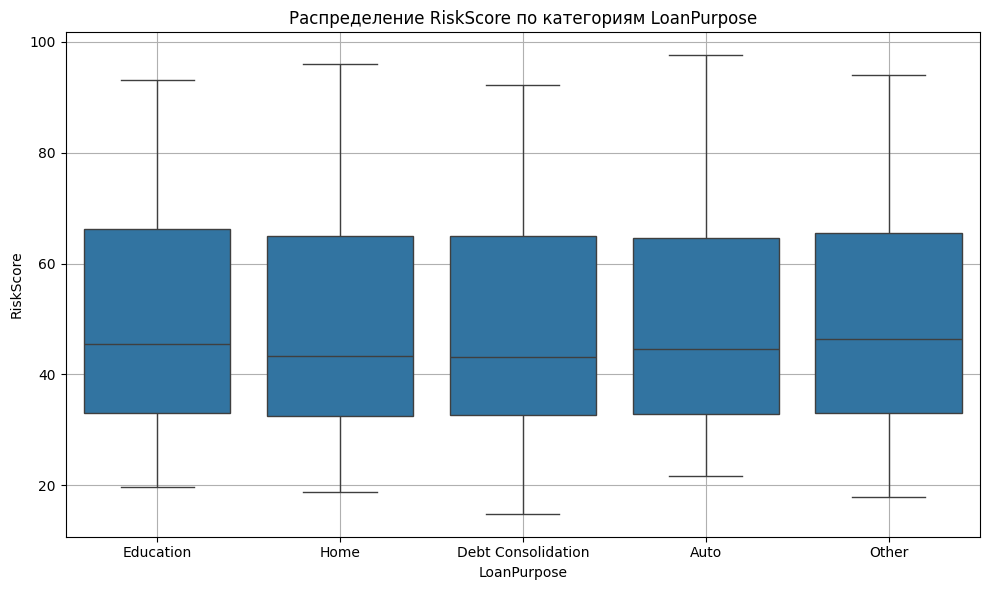

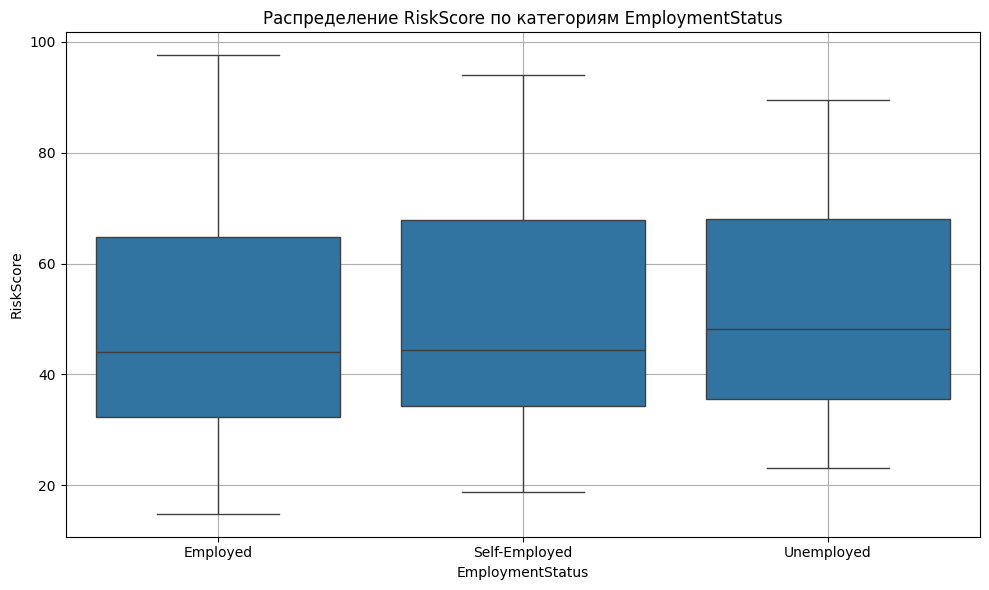

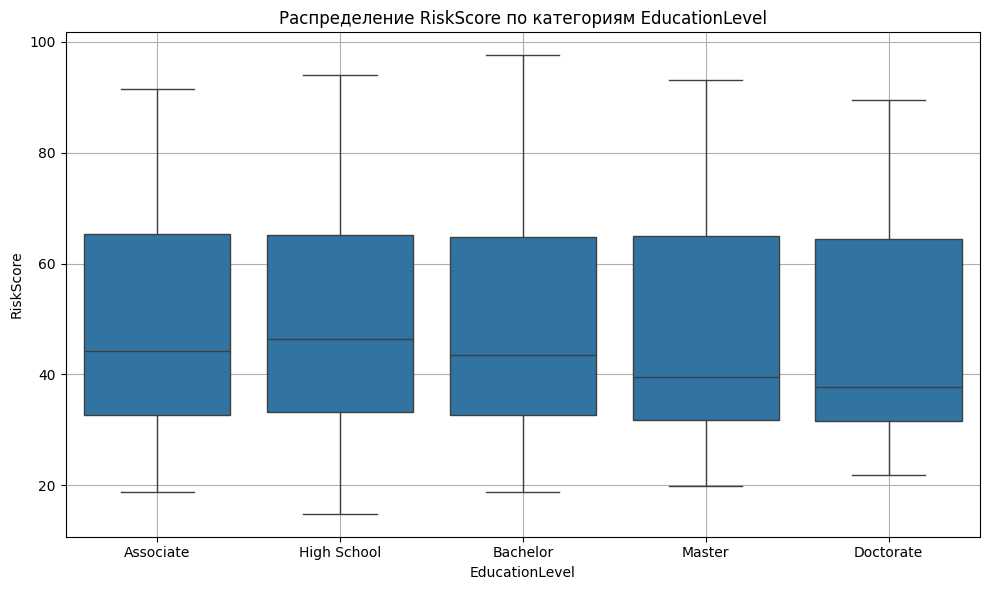

In [48]:
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_without_anomal_target, x=col, y='RiskScore')
    plt.title(f'Распределение RiskScore по категориям {col}')
    plt.xlabel(col)
    plt.ylabel('RiskScore')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Категориальные признаки слабо влияют на таргет. Наибольшая разница видна между категориями `Employed` и `Unemployed`.

Ограничим таргет значениями между первым и третьим квартилями.

In [49]:
count_outliers_iqr(prepared_train['RiskScore'])

np.int64(212)

In [50]:
prepared_train = train_without_anomal_target
count_outliers_iqr(prepared_train['RiskScore'])

np.int64(0)

Для столбцов `LoanAmount`, `MonthlyDebtPayments` `SavingsAccountBalance`, `CheckingAccountBalance` `TotalAssets`, `TotalLiabilities`, `NetWorth`, `MonthlyLoanPayment` применим логарифмическое преобразование.

In [51]:
log_norm_columns = [
    'LoanAmount', 'MonthlyDebtPayments',
    'SavingsAccountBalance', 'CheckingAccountBalance',
    'TotalAssets', 'TotalLiabilities', 'NetWorth',
    'MonthlyLoanPayment'
]

for col in log_norm_columns:
    prepared_train[col] = np.log1p(prepared_train[col])
    prepared_test[col] = np.log1p(prepared_test[col])

Добавим в датасет новые признаки, которые помогут компенсировать нелинейную связь некоторых признаков с таргетом и дадут дополнительную информацию для модели.

In [52]:
def add_features(df):
    df_copy = df.copy()

    df_copy['LoanToIncome'] = df_copy['LoanAmount'] / df_copy['AnnualIncome']
    df_copy['PaymentToIncome'] = df_copy['MonthlyLoanPayment'] / df_copy['MonthlyIncome']
    df_copy['NetLiquidAssets'] = df_copy['SavingsAccountBalance'] + df_copy['CheckingAccountBalance'] - df_copy['MonthlyDebtPayments']
    df_copy['TotalFinancialHealth'] = (df_copy['TotalAssets'] - df_copy['TotalLiabilities']) / df_copy['MonthlyIncome']
    df_copy['IncomePerDependent'] = df_copy['MonthlyIncome'] / (df_copy['NumberOfDependents'] + 1)
    df_copy['AssetToLoanRatio'] = df_copy['TotalAssets'] / df_copy['LoanAmount']
    df_copy['CreditHealthScore'] = df_copy['CreditScore'] / (df_copy['NumberOfCreditInquiries'] + 1)
    df_copy['FinancialStabilityIndex'] = df_copy['JobTenure'] * df_copy['MonthlyIncome'] / df_copy['TotalLiabilities']

    df_copy['CreditScore_sq'] = df_copy['CreditScore'] ** 2
    df_copy['Age_sq'] = df_copy['Age'] ** 2
    df_copy['Experience_sq'] = df_copy['Experience'] ** 2

    df_copy['CreditScore_PaymentHistory'] = df_copy['CreditScore'] * df_copy['PaymentHistory']
    df_copy['Income_CreditScore'] = df_copy['MonthlyIncome'] * df_copy['CreditScore']
    df_copy['Debt_CreditScore'] = df_copy['TotalDebtToIncomeRatio'] * df_copy['CreditScore']

    df_copy['AvailableIncome'] = df_copy['MonthlyIncome'] - df_copy['MonthlyDebtPayments']
    df_copy['PaymentBurden'] = df_copy['MonthlyLoanPayment'] / df_copy['AvailableIncome']
    df_copy['LoanToAsset'] = df_copy['LoanAmount'] / (df_copy['TotalAssets'] + 1)
    df_copy['DebtRatio'] = df_copy['TotalLiabilities'] / (df_copy['TotalAssets'] + 1)

    df_copy['RiskExposure'] = df_copy['LoanAmount'] / (df_copy['NetWorth'] + 1) * (df_copy['PreviousLoanDefaults'] + 1)
    df_copy['CreditRiskIndex'] = (df_copy['NumberOfCreditInquiries'] + 1) / (df_copy['CreditScore'] + 1)
    df_copy['FinancialSafetyNet'] = df_copy['SavingsAccountBalance'] / (df_copy['MonthlyLoanPayment'] + 1)

    df_copy['HasHighIncome'] = (df_copy['AnnualIncome'] > df_copy['AnnualIncome'].median()).astype(int)
    df_copy['HasGoodCredit'] = (df_copy['CreditScore'] > df_copy['CreditScore'].median()).astype(int)
    df_copy['HasStableJob'] = (df_copy['JobTenure'] > 3).astype(int)

    df_copy['ApplicationQuarter'] = ((df_copy['ApplicationMonth'] - 1) // 3 + 1).astype(int)
    df_copy['Month_sin'] = np.sin(2 * np.pi * df_copy['ApplicationMonth'] / 12)
    df_copy['Month_cos'] = np.cos(2 * np.pi * df_copy['ApplicationMonth'] / 12)

    df_copy['RepaymentCapacity'] = (df_copy['MonthlyIncome'] - df_copy['MonthlyDebtPayments']) / (df_copy['MonthlyLoanPayment'] + 1)
    df_copy['FinancialCushion'] = df_copy['NetLiquidAssets'] / df_copy['MonthlyLoanPayment']
    df_copy['OverallCreditworthiness'] = (df_copy['CreditScore'] * df_copy['PaymentHistory']) / (df_copy['PreviousLoanDefaults'] + 1)

    df_copy['LogLoanAmount'] = np.log1p(df_copy['LoanAmount'])
    df_copy['LogIncome'] = np.log1p(df_copy['AnnualIncome'])
    df_copy['LogNetWorth'] = np.log1p(np.abs(df_copy['NetWorth']) + 1) * np.sign(df_copy['NetWorth'])

    df_copy['AgeExperienceRatio'] = df_copy['Age'] / (df_copy['Experience'] + 1)
    df_copy['CreditPerAge'] = df_copy['CreditScore'] / df_copy['Age']
    df_copy['AssetPerAge'] = df_copy['TotalAssets'] / df_copy['Age']
    df_copy['IncomePerExperience'] = df_copy['AnnualIncome'] / (df_copy['Experience'] + 1)

    return df_copy

In [53]:
prepared_train = add_features(prepared_train)
prepared_test = add_features(prepared_test)

## Отбор признаков

In [54]:
def analyze_correlations(X, y, numeric_features):
    data_for_corr = X[numeric_features].copy()
    data_for_corr['target'] = y

    correlation_matrix = data_for_corr.corr()
    target_correlations = correlation_matrix['target'].drop('target').abs().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=target_correlations.head(10).values, y=target_correlations.head(10).index, palette='viridis')

    for i, v in enumerate(target_correlations.head(10).values):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

    plt.title('Топ-10 числовых признаков по корреляции с целевой переменной')
    plt.xlabel('Абсолютная величина корреляции')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций всех числовых признаков')
    plt.tight_layout()
    plt.show()

    top15_features = target_correlations.head(15).index.tolist()
    top15_features.append('target')
    plt.figure(figsize=(12, 10))
    sns.heatmap(data_for_corr[top15_features].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Матрица корреляций для топ-15 признаков')
    plt.tight_layout()
    plt.show()

In [55]:
def select_k_best(X_train_preprocessed, y_train, X_columns):
    selector = SelectKBest(f_regression, k=min(20, X_train_preprocessed.shape[1]))
    selector.fit(X_train_preprocessed, y_train)

    mask = selector.get_support()

    selected_features = []
    feature_scores = []

    for i, column in enumerate(X_columns):
        if mask[i]:
            selected_features.append(column)
            feature_scores.append((column, selector.scores_[i]))

    feature_scores.sort(key=lambda x: x[1], reverse=True)

    return selected_features, feature_scores

def recursive_feature_elimination(X_train_preprocessed, y_train, X_columns):
    model = LinearRegression()
    selector = RFE(model, n_features_to_select=min(20, X_train_preprocessed.shape[1]), step=1)
    selector.fit(X_train_preprocessed, y_train)

    mask = selector.get_support()

    selected_features = []
    for i, column in enumerate(X_columns):
        if mask[i]:
            selected_features.append(column)

    return selected_features

def lasso_selection(X_train_preprocessed, y_train, X_columns):
    lasso = Lasso(alpha=0.01, random_state=RANDOM_STATE)
    lasso.fit(X_train_preprocessed, y_train)

    feature_importance = np.abs(lasso.coef_)

    feature_scores = [(X_columns[i], importance) for i, importance in enumerate(feature_importance) if importance > 0]

    feature_scores.sort(key=lambda x: x[1], reverse=True)

    selected_features = [feature for feature, importance in feature_scores]

    return selected_features, feature_scores

def random_forest_selection(X_train_preprocessed, y_train, X_columns):
    rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    rf.fit(X_train_preprocessed, y_train)

    feature_importance = rf.feature_importances_

    feature_scores = [(X_columns[i], importance) for i, importance in enumerate(feature_importance)]

    feature_scores.sort(key=lambda x: x[1], reverse=True)

    selected_features = [feature for feature, _ in feature_scores[:min(20, len(feature_scores))]]

    return selected_features, feature_scores

def select_features(X, y, numeric_features, categorical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    num_feature_names = numeric_features

    ohe = preprocessor.named_transformers_['cat']
    cat_feature_names = []

    if len(categorical_features) > 0:
        for i, feature in enumerate(categorical_features):
            categories = ohe.categories_[i][1:]
            for category in categories:
                cat_feature_names.append(f"{feature}_{category}")

    feature_names = num_feature_names + cat_feature_names

    k_best_features, k_best_scores = select_k_best(X_train_preprocessed, y_train, feature_names)
    rfe_features = recursive_feature_elimination(X_train_preprocessed, y_train, feature_names)
    lasso_features, lasso_scores = lasso_selection(X_train_preprocessed, y_train, feature_names)
    rf_features, rf_scores = random_forest_selection(X_train_preprocessed, y_train, feature_names)

    plt.figure(figsize=(12, 6))
    k_best_top10 = k_best_scores[:10]
    ax = sns.barplot(x=[score for _, score in k_best_top10],
                     y=[feature for feature, _ in k_best_top10],
                     palette='Blues_d')
    plt.title('Топ-10 признаков по F-статистике (SelectKBest)')
    plt.xlabel('F-статистика')
    plt.ylabel('Признак')
    for i, (_, score) in enumerate(k_best_top10):
        ax.text(score + 1, i, f'{score:.1f}', va='center')
    plt.tight_layout()
    plt.show()

    if lasso_scores:
        plt.figure(figsize=(12, 6))
        lasso_top10 = lasso_scores[:10]
        ax = sns.barplot(x=[score for _, score in lasso_top10],
                         y=[feature for feature, _ in lasso_top10],
                         palette='Reds_d')
        plt.title('Топ-10 признаков по абсолютной величине коэффициентов Lasso')
        plt.xlabel('|Коэффициент|')
        plt.ylabel('Признак')
        for i, (_, score) in enumerate(lasso_top10):
            ax.text(score + 0.01, i, f'{score:.3f}', va='center')
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(12, 6))
    rf_top10 = rf_scores[:10]
    ax = sns.barplot(x=[score for _, score in rf_top10],
                     y=[feature for feature, _ in rf_top10],
                     palette='Greens_d')
    plt.title('Топ-10 признаков по важности в Random Forest')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    for i, (_, score) in enumerate(rf_top10):
        ax.text(score + 0.01, i, f'{score:.3f}', va='center')
    plt.tight_layout()
    plt.show()

    feature_selection_count = {}

    for feature in set(k_best_features + rfe_features + lasso_features + rf_features):
        count = 0
        if feature in k_best_features:
            count += 1
        if feature in rfe_features:
            count += 1
        if feature in lasso_features:
            count += 1
        if feature in rf_features:
            count += 1
        feature_selection_count[feature] = count

    sorted_features = sorted(feature_selection_count.items(), key=lambda x: x[1], reverse=True)

    voting_features = [feature for feature, count in sorted_features if count >= 2]
    voting_counts = [count for feature, count in sorted_features if count >= 2]

    plt.figure(figsize=(14, 8))
    colors = ['lightgray', 'lightblue', 'cornflowerblue', 'royalblue']
    ax = sns.barplot(x=voting_counts, y=voting_features, palette=colors)
    plt.title('Признаки, выбранные несколькими методами (минимум 2 голоса)')
    plt.xlabel('Количество методов, выбравших признак')
    plt.ylabel('Признак')
    for i, count in enumerate(voting_counts):
        ax.text(count + 0.1, i, str(count), va='center')
    plt.tight_layout()
    plt.show()

    recommended_features = [feature for feature, count in sorted_features if count >= 2]

    return recommended_features

In [56]:
X_train = prepared_train.drop('RiskScore', axis=1)
y_train = prepared_train['RiskScore']

numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

display(X_train, y_train)

Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration MaritalStatus  \
0     27.0       66829.0        549.0    9.757941          60.0      Divorced   
1     55.0      172147.0        850.0    9.687258          36.0       Widowed   
2     51.0      300000.0        850.0   10.556776          36.0       Married   
3     25.0       34683.0        847.0    9.861988          48.0       Married   
4     55.0      300000.0        850.0   10.323447          48.0        Single   
...    ...           ...          ...         ...           ...           ...   
9783  27.0       15000.0        361.0    9.878477          36.0        Single   
9784  49.0      185082.0        573.0    8.915701          84.0       Married   
9785  55.0      296728.0        850.0   10.695643          84.0      Divorced   
9786  33.0      206277.0        722.5    9.991018          24.0       Married   
9787  28.0       87240.0        649.0    9.609251          12.0       Married   

      NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0                    1.0                Rent             6.999422   
1                    1.0            Mortgage             5.356586   
2                    0.0            Mortgage             6.304449   
3                    0.0               Other             5.036953   
4                    2.0                Rent             6.333280   
...                  ...                 ...                  ...   
9783                 1.0               Other             6.434547   
9784                 0.0            Mortgage             6.853299   
9785                 2.0            Mortgage             6.173786   
9786                 0.0            Mortgage             5.988961   
9787                 3.0            Mortgage             5.030438   

      CreditCardUtilizationRate  ...  RepaymentCapacity  FinancialCushion  \
0                      0.151985  ...         768.843380          1.019180   
1                      0.175693  ...        1979.196677          1.269184   
2                      0.444605  ...        3068.140811          1.347489   
3                      0.188452  ...         399.967541          1.378532   
4                      0.273431  ...        3275.963374          0.922307   
...                         ...  ...                ...               ...   
9783                   0.409411  ...         159.862948          1.617914   
9784                   0.095426  ...        2483.985765          1.994928   
9785                   0.373804  ...        3196.292378          1.746539   
9786                   0.070873  ...        1875.479951          1.070614   
9787                   0.085640  ...         885.216359          1.206047   

      OverallCreditworthiness  LogLoanAmount  LogIncome  LogNetWorth  \
0                    12627.00       2.375644  11.109907     2.522928   
1                    22950.00       2.369052  12.056110     2.501736   
2                    17850.00       2.447272  12.611541     2.676680   
3                    22869.00       2.385269  10.454034     2.409615   
4                    29750.00       2.426876  12.611541     2.343007   
...                       ...            ...        ...          ...   
9783                  4873.50       2.386786   9.615872     2.513889   
9784                 10887.00       2.294119  12.128560     2.446515   
9785                 18700.00       2.459216  12.600575     2.321957   
9786                  8308.75       2.397078  12.236980     2.503026   
9787                 11033.00       2.361726  11.376430     2.657645   

      AgeExperienceRatio  CreditPerAge  AssetPerAge  IncomePerExperience  
0               5.400000     20.333333     0.400787         13365.800000  
1               1.617647     15.454545     0.207786          5063.147059  
2               1.758621     16.666667     0.246775         10344.827586  
3              25.000000     33.880000     0.379126         34683.000000  
4               1.718750     15.454545  

0       66.176500
1       28.495737
2       34.488104
3       36.910753
4       31.347091
          ...    
9783    76.185933
9784    41.213393
9785    43.699684
9786    33.516126
9787    56.104270
Name: RiskScore, Length: 9788, dtype: float64

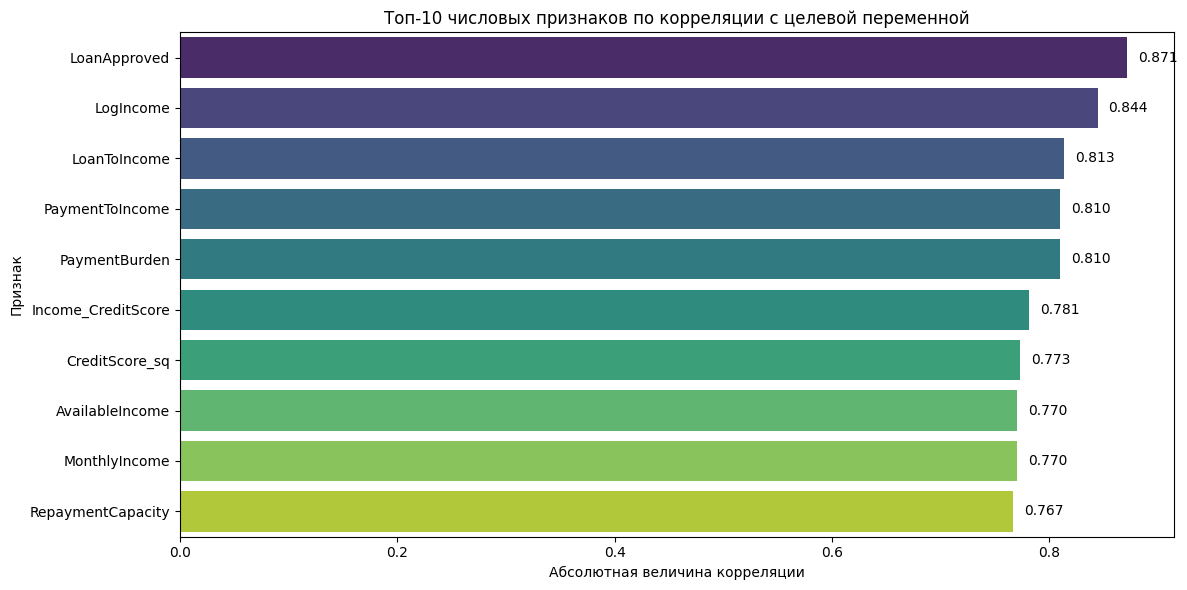

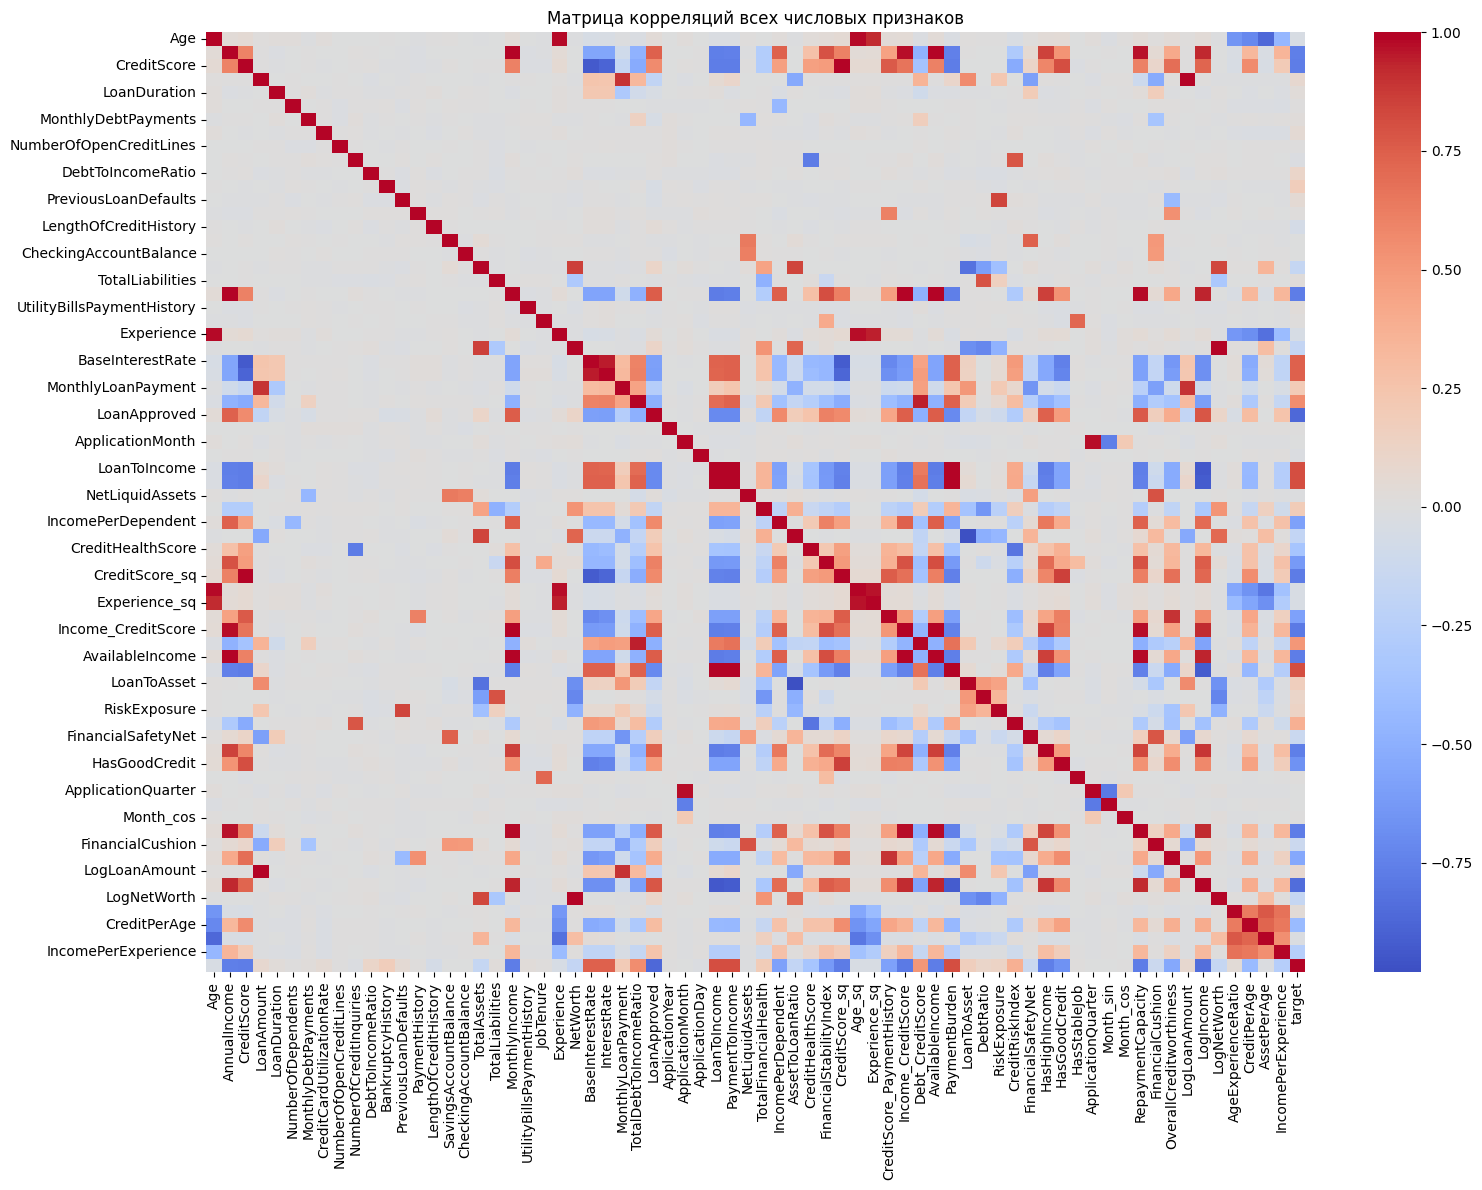

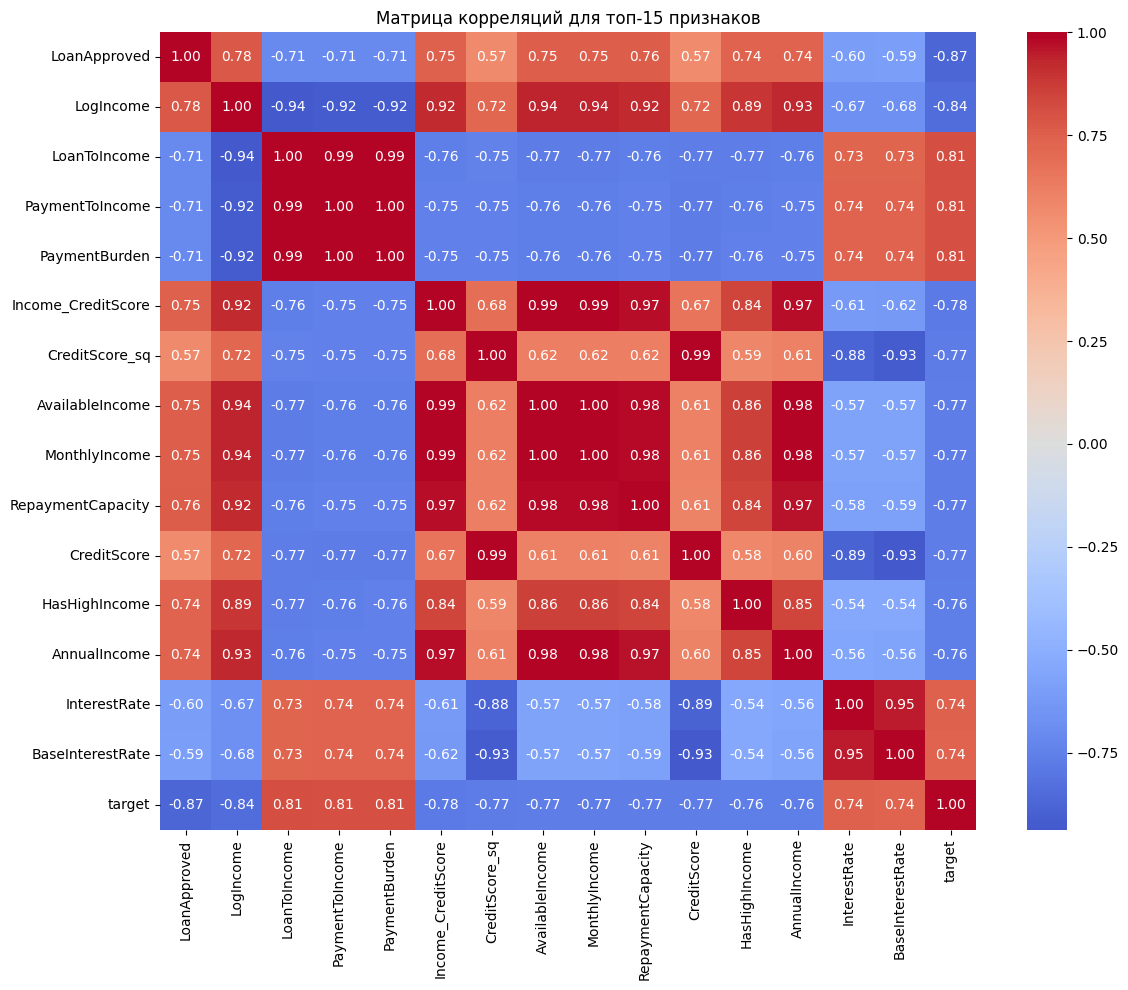

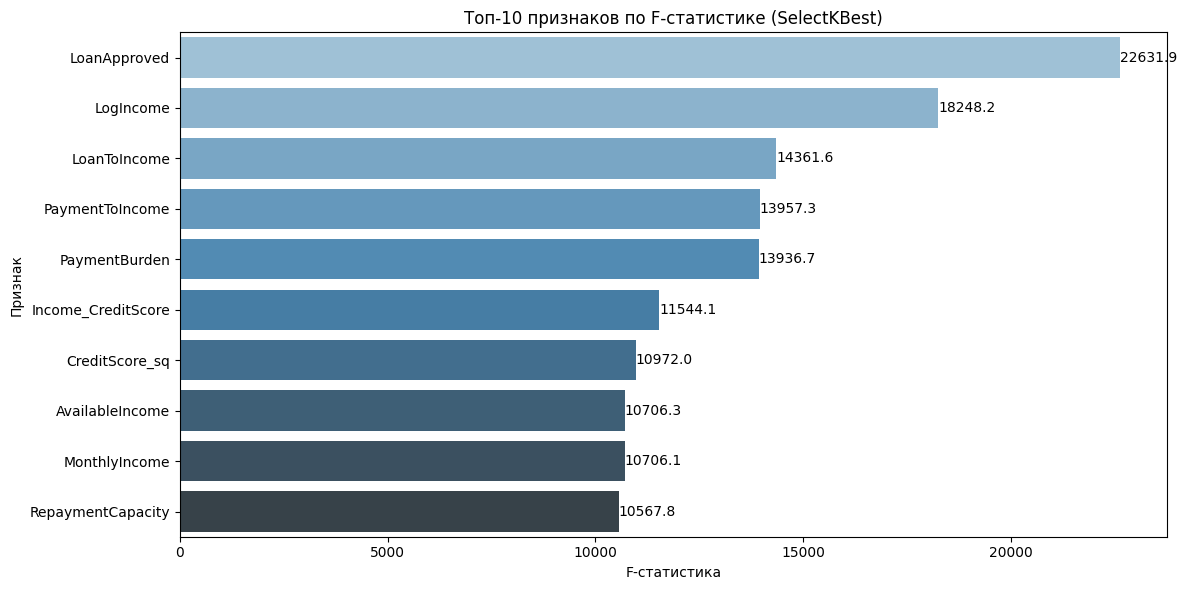

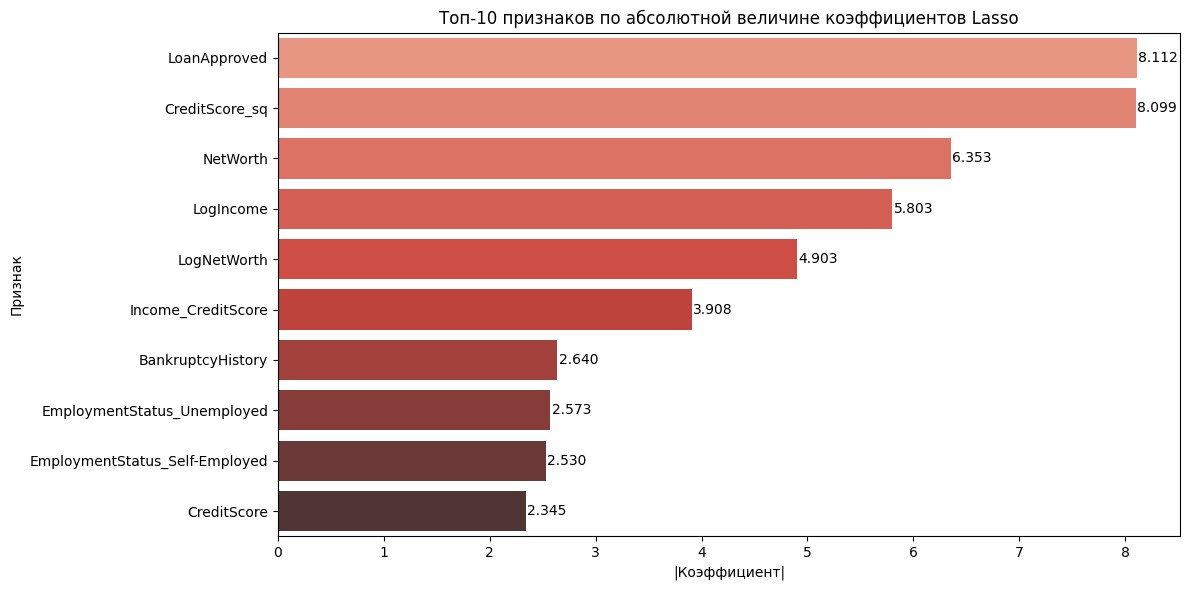

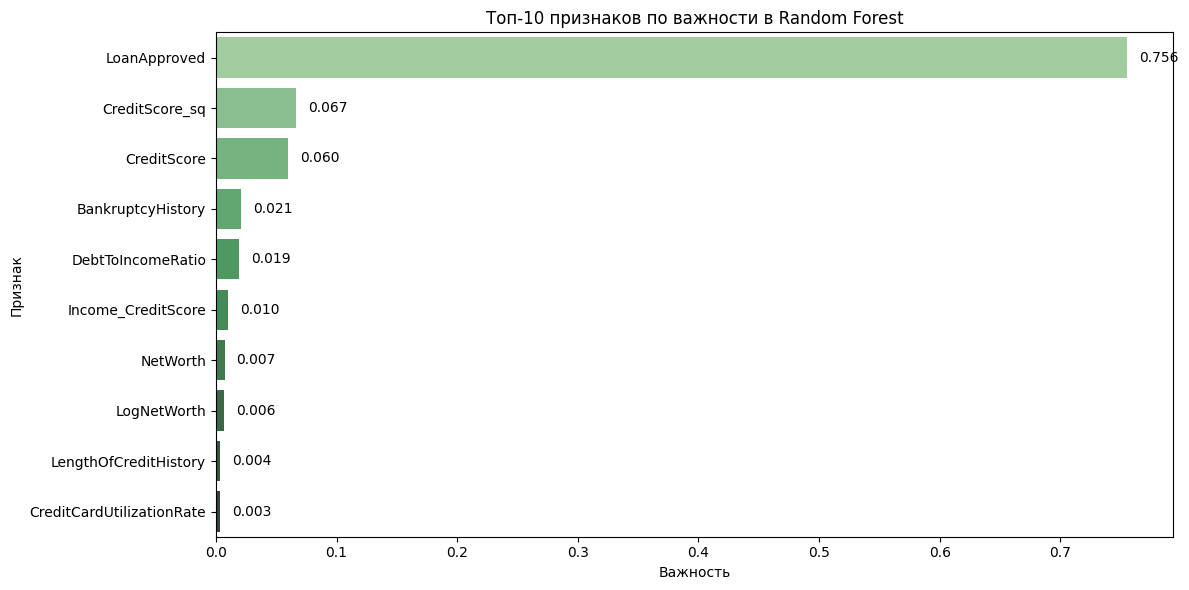

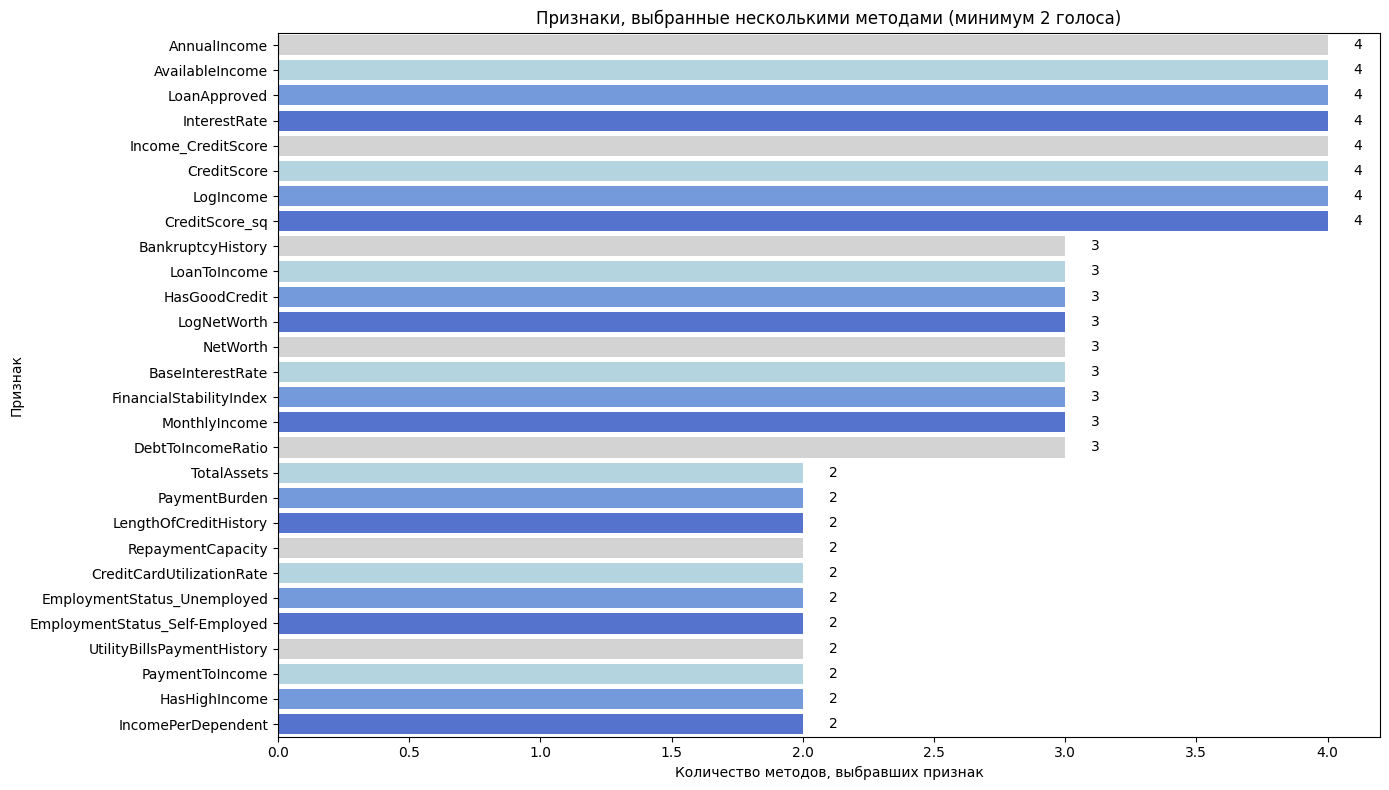

['AnnualIncome',
 'AvailableIncome',
 'LoanApproved',
 'InterestRate',
 'Income_CreditScore',
 'CreditScore',
 'LogIncome',
 'CreditScore_sq',
 'BankruptcyHistory',
 'LoanToIncome',
 'HasGoodCredit',
 'LogNetWorth',
 'NetWorth',
 'BaseInterestRate',
 'FinancialStabilityIndex',
 'MonthlyIncome',
 'DebtToIncomeRatio',
 'TotalAssets',
 'PaymentBurden',
 'LengthOfCreditHistory',
 'RepaymentCapacity',
 'CreditCardUtilizationRate',
 'EmploymentStatus_Unemployed',
 'EmploymentStatus_Self-Employed',
 'UtilityBillsPaymentHistory',
 'PaymentToIncome',
 'HasHighIncome',
 'IncomePerDependent']

In [57]:
analyze_correlations(X_train, y_train, numeric_features)

recommended_features = select_features(X_train, y_train, numeric_features, categorical_features)

recommended_features

## Обучение моделей

In [58]:
recommended_numeric = [f for f in recommended_features if f in numeric_features]
recommended_categorical = [f for f in recommended_features if f in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), recommended_numeric),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), recommended_categorical)
])

In [59]:
def evaluate_model_cv(
    model,
    X,
    y,
    cv_method: Literal['kfold', 'loo'] = 'kfold',
    n_splits: int = 5,
    shuffle: bool = False,
    random_state: Optional[int] = None
) -> dict:
    if cv_method == 'kfold':
        cv = MyKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    elif cv_method == 'loo':
        cv = MyLeaveOneOut()
    else:
        raise ValueError("Invalid cv_method. Choose 'kfold' or 'loo'.")

    mse_scores = []
    r2_scores = []
    mae_scores = []
    mape_scores = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]  # ← исправлено
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(preprocessor.fit_transform(X_train), y_train)
        y_pred = model.predict(preprocessor.transform(X_test))

        mse_scores.append(my_mse(y_test, y_pred))
        r2_scores.append(my_r2(y_test, y_pred))
        mae_scores.append(my_mae(y_test, y_pred))
        mape_scores.append(my_mape(y_test, y_pred))

    results = {
        'mse': np.mean(mse_scores),
        'r2': np.mean(r2_scores),
        'mae': np.mean(mae_scores),
        'mape': np.mean(mape_scores)
    }

    return results

In [60]:
for (model, model_name) in [
    (MyLinearRegression(verbose=False), 'default'),
    (MyLinearRegression(penalty='l1', solver='gradient', verbose=False), 'l1'),
    (MyLinearRegression(penalty='l2', verbose=False), 'l2'),
    (MyLinearRegression(penalty='elasticnet', solver='gradient', verbose=False), 'elasticnet')
]:
    kfold_res = evaluate_model_cv(
        model,
        X_train,
        y_train,
        'kfold',
        5,
        True,
        random_state=RANDOM_STATE
    )
    df_metrics = pd.DataFrame(kfold_res.items(), columns=['Метрика', 'Значение'])
    df_metrics['Значение'] = df_metrics['Значение'].round(4)

    display(df_metrics)

Метрика  Значение
0     mse   14.8727
1      r2    0.9499
2     mae    2.9915
3    mape    0.0688

Метрика  Значение
0     mse   19.2672
1      r2    0.9351
2     mae    3.3871
3    mape    0.0762

Метрика  Значение
0     mse   14.8938
1      r2    0.9498
2     mae    2.9937
3    mape    0.0687

Метрика  Значение
0     mse   28.3084
1      r2    0.9047
2     mae    4.1408
3    mape    0.0942

Обычная линейная регрессия показала лучшие результаты.

In [61]:
prepared_test_without_id, prepared_test_id = prepared_test.drop(columns=['ID'], axis=1), prepared_test['ID']

In [62]:
lr = MyLinearRegression()
lr.fit(preprocessor.fit_transform(X_train), y_train)
test_pred = lr.predict(preprocessor.transform(prepared_test_without_id))

In [63]:
def predict_to_csv(pred, path='pred.csv'):
    pd.DataFrame({
        'ID': prepared_test_id,
        'RiskScore': pred
    }).to_csv(path, index=False)
    print(path, 'saved')

In [64]:
predict_to_csv(test_pred, 'default_lr_with_feature_selection.csv')

default_lr_with_feature_selection.csv saved
